In [944]:
import pandas as pd     # data manipulation
import numpy as np      # numerical computation
import warnings
warnings.filterwarnings('ignore')

from scipy import stats 
import seaborn as sns 
from matplotlib import pyplot as plt 
from matplotlib import style 
from cycler import cycler 
import matplotlib

# create cycling objects
default_cycler = (cycler(color=['0.3', '0.5', '0.7', '0.5']) 
                  + cycler(linestyle=['-', '--', ':', '-.']) 
                  #+ cycler(marker=['o', 'v', 'd', 'p'])
                  )

color=['0.3', '0.5', '0.7', '0.5']
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams.update({'figure.dpi': 400})

#### Underlying assumptions

The first assumption is that of consistency, ie the potential outcome is consistent with the treatment ie $Y_i(t)=Y $ when $T=t$. This means there are no hidden versions of the treatment other than the ones specified with $T$. For example, if the treatment comes in multiple doses but you account for one does and control, this assumptions is violated. Inconsistency also means that the treatment is ill defined ie instead of enumerating the different types of treatment used, they are all bunched up together as one.

The second assumption is that of stable unit of treatment value (SUTVA). This assumption means that there is no interference from other units. The effect of the treatment of one unit is not influenced by the treatment of other units ie $Y_i(T_i) = Y_i(T_1, T_2, ..., T_i, ..., T_n)$. This assumption is violated for example, with vaccinations, where control members whose relatives are in the treated group, receive some protection from disease.

The final assumption is the independence assumption which is that the potential outcomes are independent of the treatment : $(Y_1,Y_0)⊥T$. The treatment gives you no information about potential outcomes, so $E[Y_0|T=1] =E[Y_0|T=0]=E[Y_0]$. Independence is intended to make treated and control groups exchangeable. 


#### Randomized experiments

Association is not the same as causation. This is because association is the sum of the average treatment effect on the treated and the bias, which is the difference between the untreated potential outcomes of the treated and control groups.

$E[Y|T=1] - E[Y|T=0] = E[Y_1-Y_0|T=1] + E[Y_0|T=1] -E[Y_0|T=0]$

$E[Y|T=1] - E[Y|T=0]= ATT + Bias$

The measured association is attributable to causation if there is no bias, and that happens if $E[Y_t|T=1]=E[Y_t|T=0]$. Randomized experiments attempt to brute-force independence which means that:

$E[Y_0|T=1]=E[Y_0|T=0]=E[Y_0]$


$E[Y_1|T=1]=E[Y_1|T=0]=E[Y_1]$

$E[Y|T=1] - E[Y|T=0] = E[Y_1|T=1] - E[Y_0|T=0] = E[Y_1] - E[Y_0] = ATE$

Randomized data is different from observational data. Randomized data describes data where the assignment mechanism is fully known and nondeterministic. Observational data describes data where you can see which units got the treatment but you dont know how that treatment got assigned.


#### An A/B Testing Example

Just a reminder, but remember that conditioning just means subset. Also even if independence should hold in theory in randomized experiments or randomized controlled trials (RCTs), it does not necessarily hold in practice. One way to evaluate balance is to check the normalized differences between treatment groups.

$\frac{\hat \mu_{tr} - \hat \mu_{co}}{\sqrt{(\hat \sigma_{tr}^2 + \hat \sigma_{co}^2 )/2}}$

In [945]:
data = pd.read_csv('data/cross_sell_email.csv')
data.head()

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0


In [946]:
# Types of treatments
data.cross_sell_email.unique()

array(['short', 'long', 'no_email'], dtype=object)

In [947]:
# average conversion for each of the treatment groups (as estimate of causal effect)
data.groupby(['cross_sell_email']).mean()

,gender,age,conversion
cross_sell_email,,,
long,0.550459,21.752294,0.055046
no_email,0.542553,20.489362,0.042553
short,0.633333,20.991667,0.125000


In [948]:
# estimate of ATE ie difference between treated group and control group
short_control = 0.125 - 0.042553            # treatment 1
long_control = 0.055046 - 0.042553          # treatment 2
print(short_control, long_control)

0.08244699999999999 0.012492999999999997


In [949]:
# Evaluating balance by checking normalized differences between treatment groups
X = ['gender', 'age']     # check if control and treated groups are balanced based on features
mu = data.groupby("cross_sell_email")[X].mean()     # mean of features for treated and control groups
var = data.groupby("cross_sell_email")[X].var()     # variance of features for treated and control groups

norm_diff = ((mu - mu.loc["no_email"])/ np.sqrt((var + var.loc["no_email"])/2))

In [950]:
mu # control (no_email) differs significantly from treatments: short in gender and long in age

,gender,age
cross_sell_email,,
long,0.550459,21.752294
no_email,0.542553,20.489362
short,0.633333,20.991667


In [951]:
var

,gender,age
cross_sell_email,,
long,0.249745,33.521407
no_email,0.250858,31.542896
short,0.234174,34.562955


In [952]:
norm_diff # there seems to be gender proportion difference comparing short to no_email

,gender,age
cross_sell_email,,
long,0.015802,0.221423
no_email,0.000000,0.000000
short,0.184341,0.087370


The normalized difference shouldn't be too small or too large; a good rule of thumb is to use a threshold of 0.5. Clearly we don't have a difference that high, but its clear that the group that got the short email has a significant difference in gender, while the group that got the long email has a significant difference in age.

In [953]:
df = pd.read_csv('data/enem_scores.csv')
df.sort_values(by='avg_score', ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


Text(0.5, 1.0, 'Number of Students of 1% Top Schools (Right)')

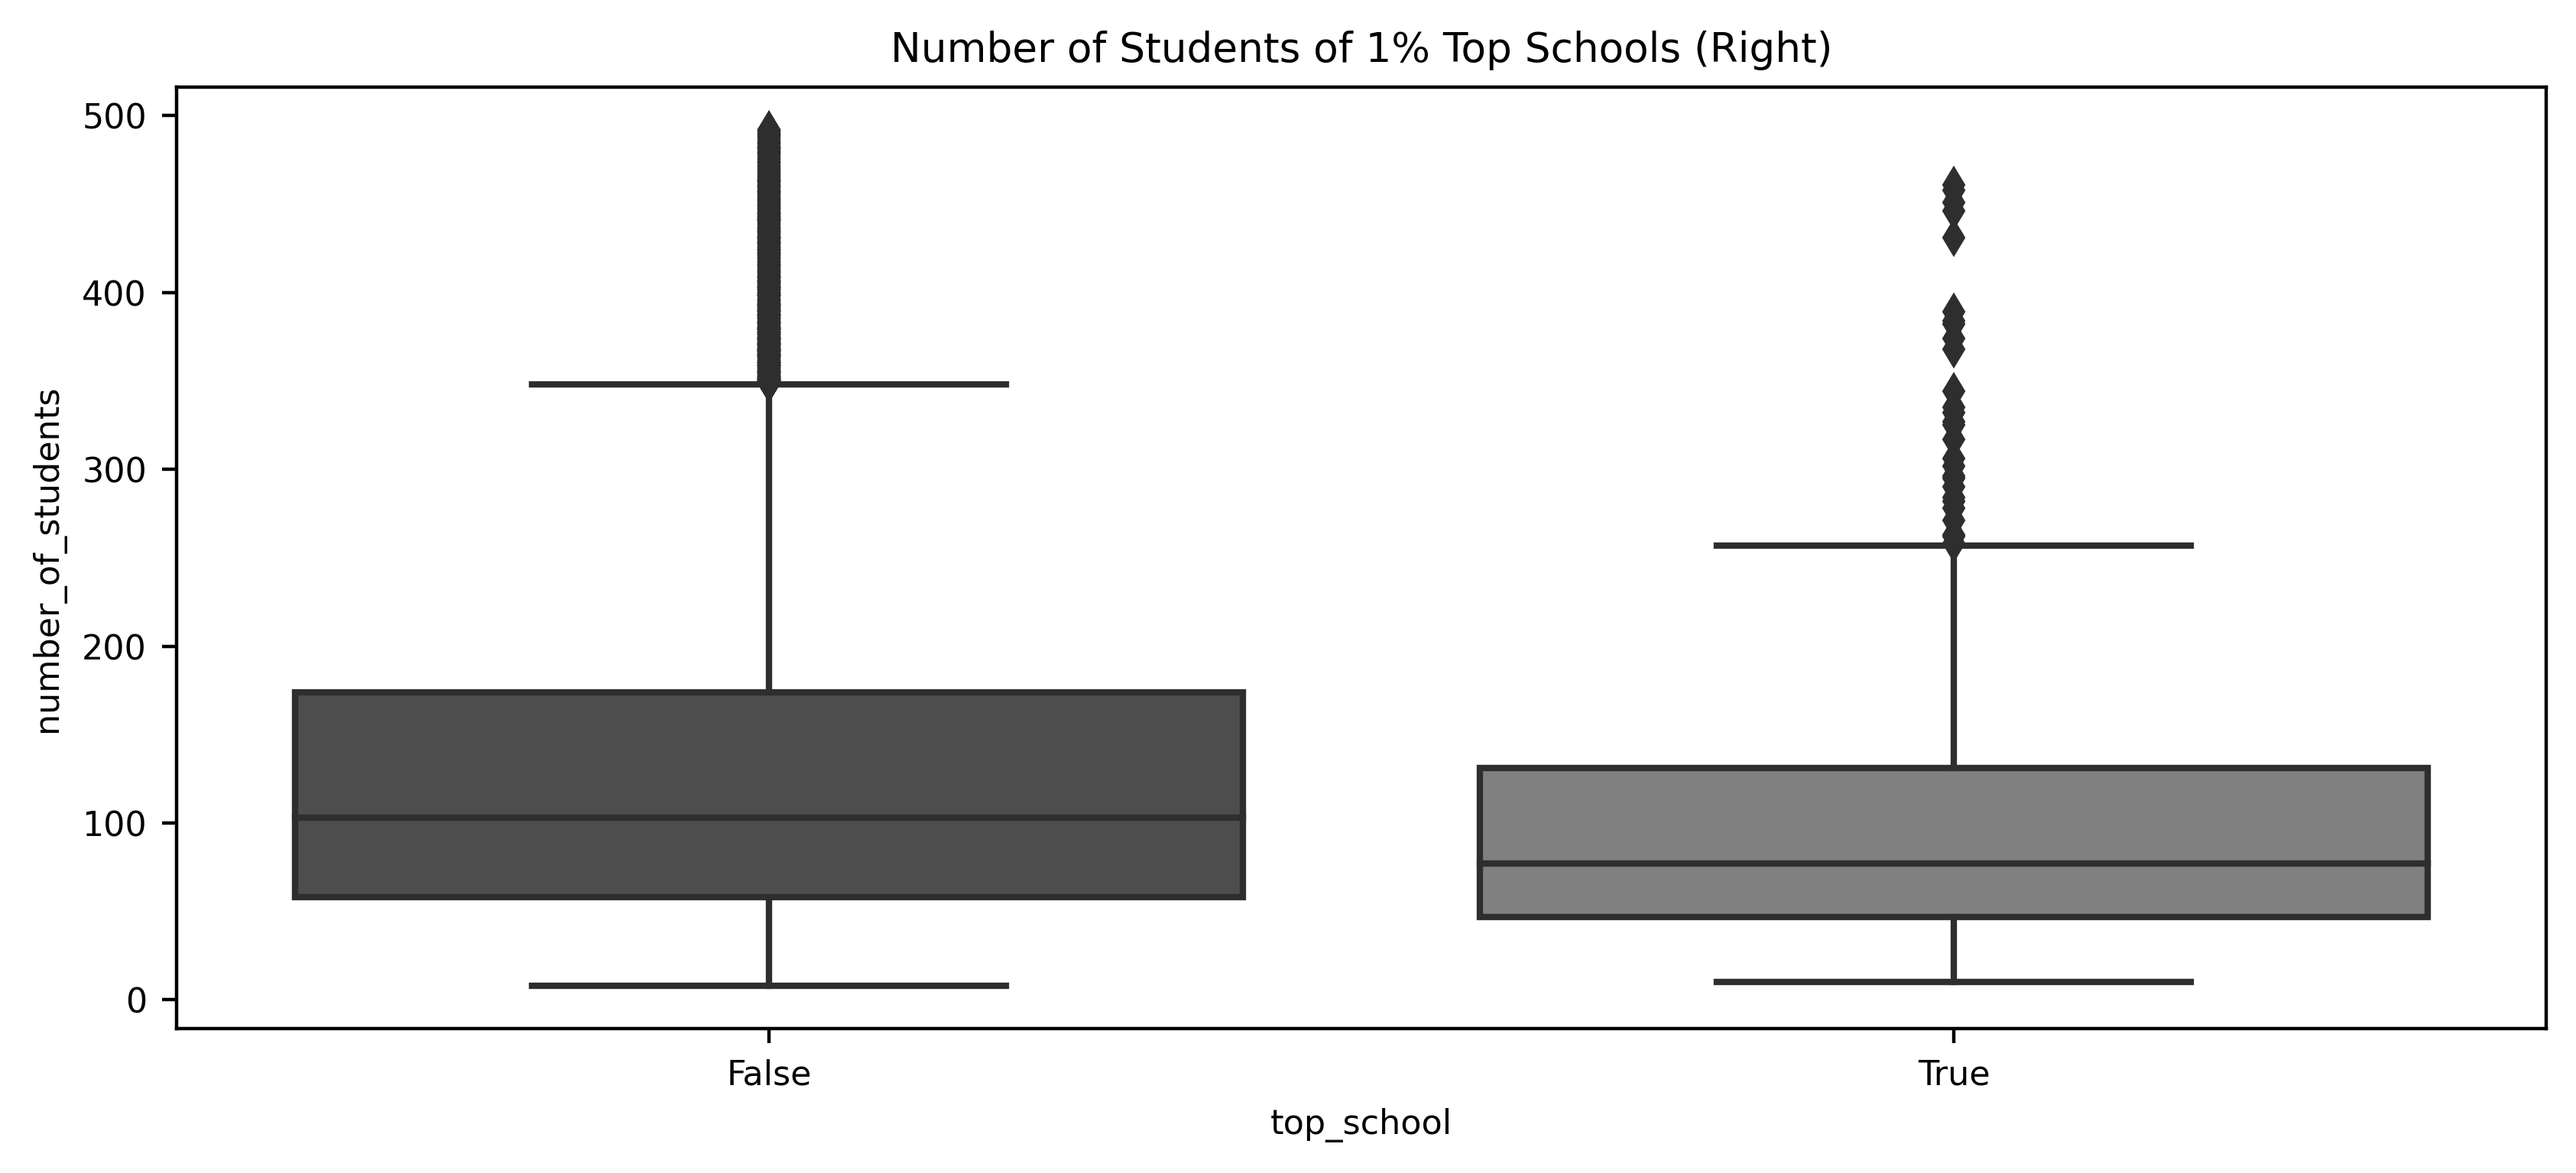

In [954]:
# create data for box plot, 
# filter out outliers above 98% percentile of student size for easy visualization
plot_data = (df.assign(top_school=df["avg_score"] >= np.quantile(df["avg_score"], .99)) # top sch is treatment
             [["top_school", "number_of_students"]] # filter these columns after adding top_school column
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(10,4)) # boxplot of feature vs treatment
ax = sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)")

The schools (and the specific years) that scored in the 99th percentile of average scores were significantly different in class size than the rest. If there was some treatment offered to the 99th percentile schools, we cant say the difference is due to the treatment only since the difference in class sizes constitutes a bias. In otherwords, the control and treated groups are not exchangeable, and that is one reason why association is not equal to causation.

Text(0.5, 1.0, 'ENEM Score by Number of Students in the School')

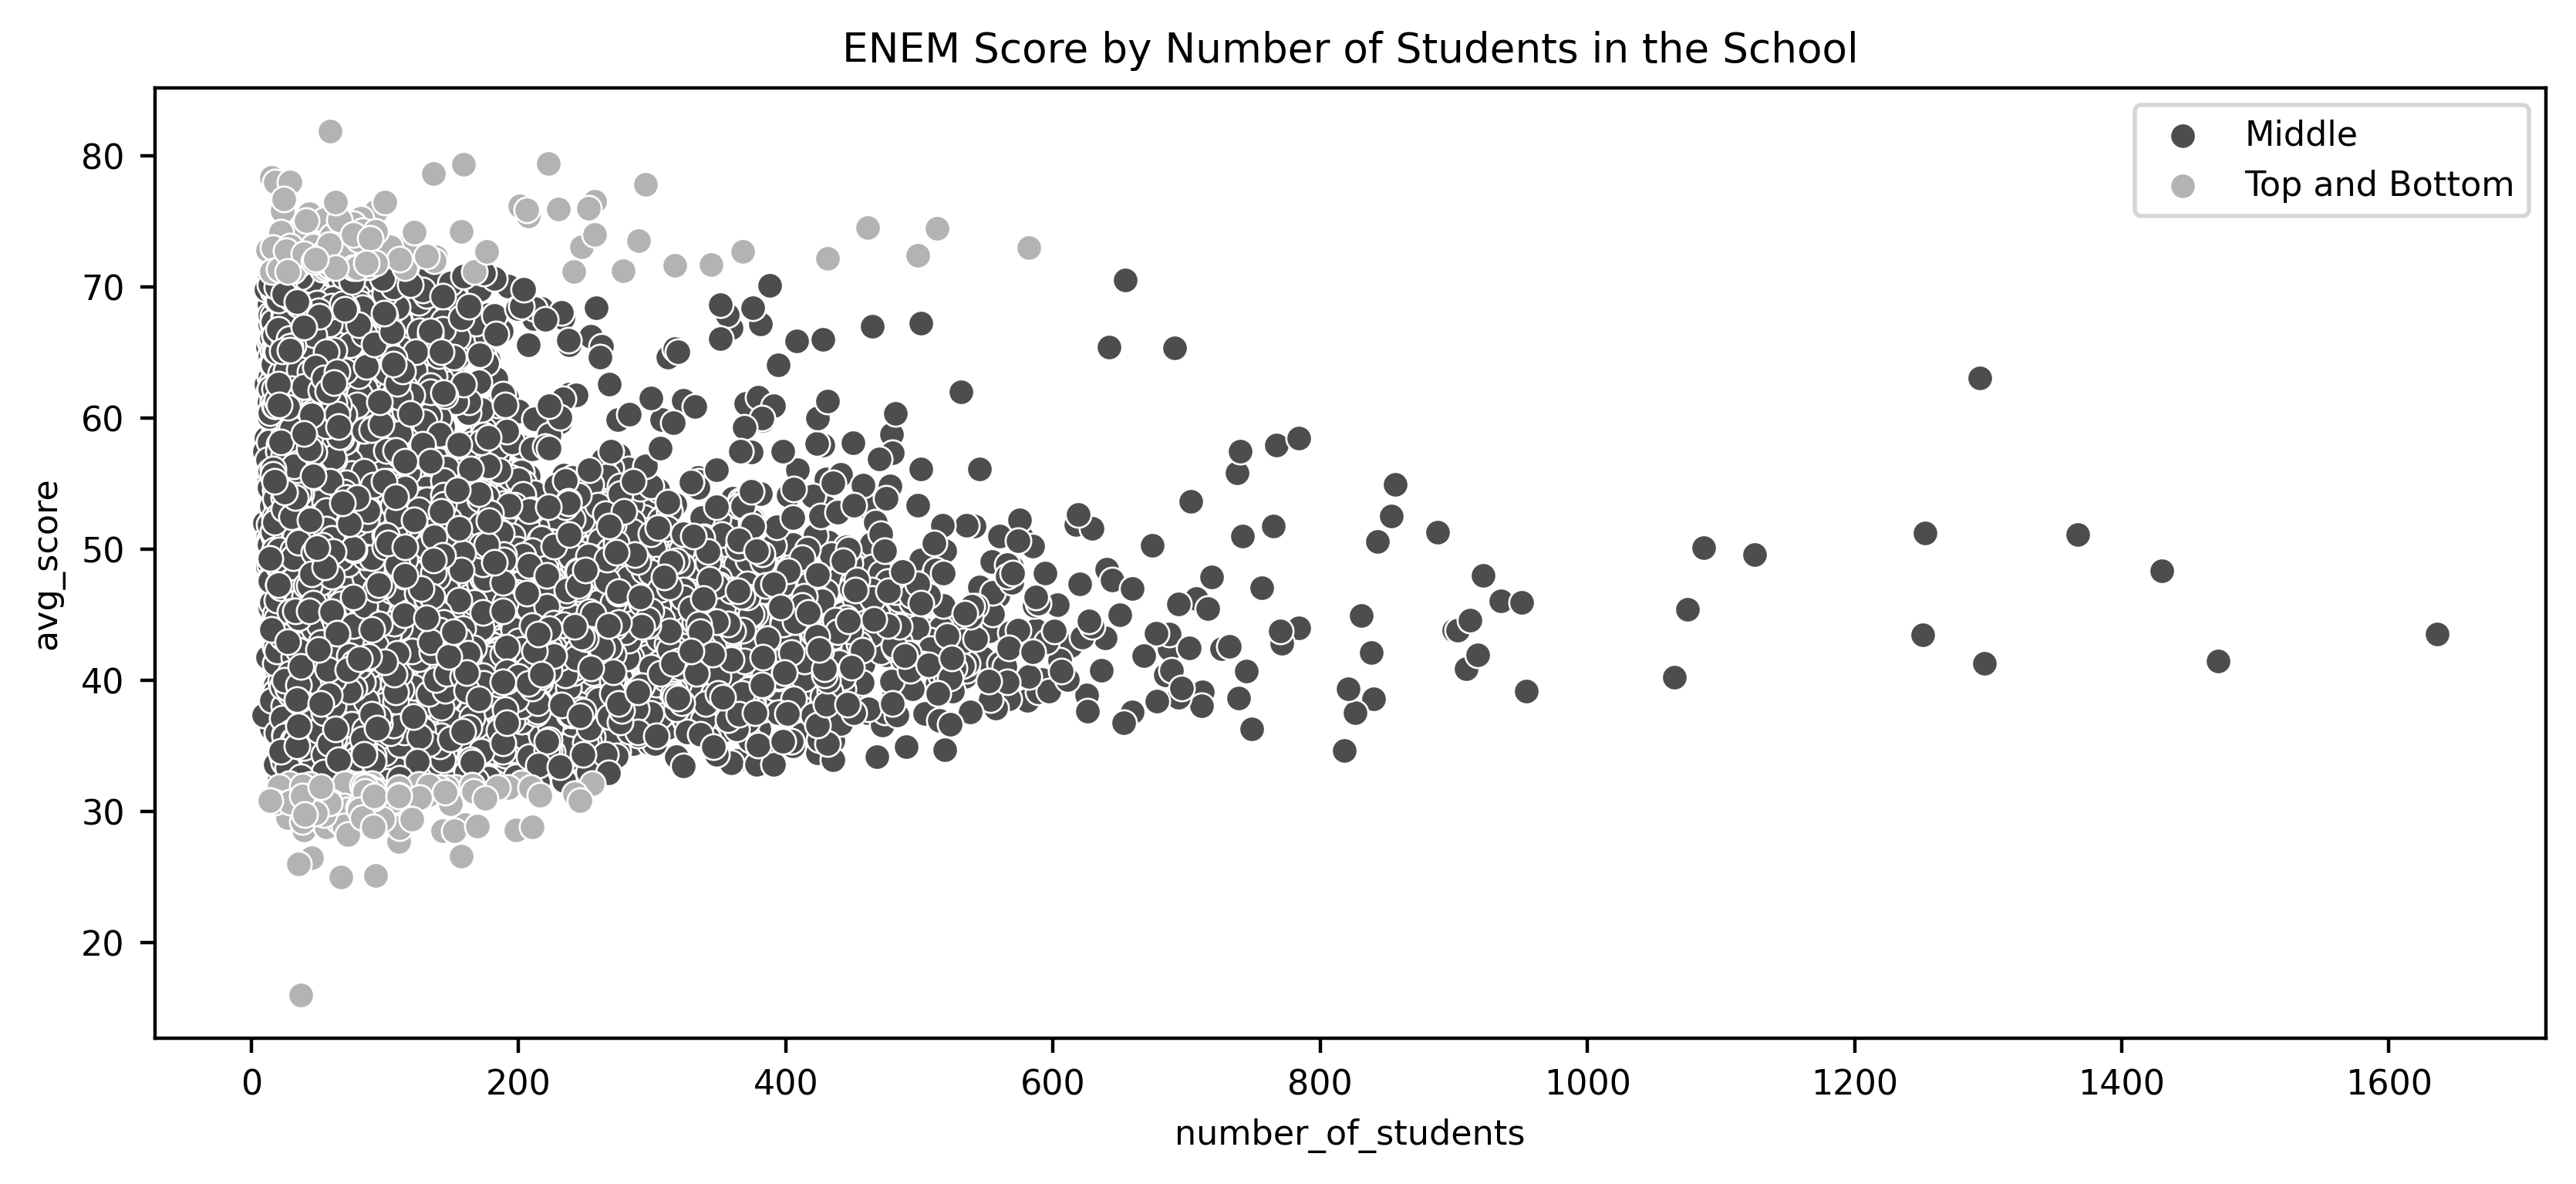

In [955]:
# visualization of student size vs avg_score (small sizes have the best and worst avg_score)
q_99 = np.quantile(df['avg_score'], .99)        # 99th percentile avg score
q_01 = np.quantile(df['avg_score'], .01)        # 1st percentile avg score

plot_data = (df
             .sample(10000)
             .assign(Group=lambda d:    # np.select(cond, choice, default)
                     np.select([(d['avg_score']>q_99) | (d['avg_score']<q_01)], 
                               ['Top and Bottom'], 'Middle'))) # assign col Group = Top and Bottom / Middle

plt.figure(figsize=(10,4))

sns.scatterplot(y='avg_score', 
                x="number_of_students", 
                data=plot_data.query("Group=='Middle'"), 
                label="Middle")         # query same as df[df[col] == 'val']

ax = sns.scatterplot(y='avg_score', x="number_of_students", 
                     data=plot_data.query("Group!='Middle' "), 
                     color="0.7",
                     label="Top and Bottom")
plt.title("ENEM Score by Number of Students in the School")


The classes in the 99th percentile and surprisingly the 1st percentile, differ from the rest in class sizes. Specifically the 99th percentile and 1st percentile classes tend to have smaller class sizes. In fact the 1st percentile classes tend to have the smallest class sizes. So again if some treatment is being touted as the reason for the average score, clearly there is bias extending from the fact that the treated and control groups are not exchangeable.

#### Standard Error of Our Estimates

To find the confidence interval around a mean value, we need the standard deviation of a distibution of sample means, centered around the observed mean value. The standard deviation of the distribution of sample means is called the standard error. Ideally, we would have multiple samples to construct the distribution of sample means and find the standard error. However, we can estimate the standard error using a single sample. Given the standard error of the observed sample $\sigma$ and the number of observations in the sample ($n$), the standard error is as follows:

$\sigma_{se}= \frac{\sigma}{\sqrt{n}}$


In [956]:
# Get the subsets of data corresponding to all defined treatments
data = pd.read_csv('data/cross_sell_email.csv')
short_email = data.query("cross_sell_email=='short'")["conversion"]
long_email = data.query("cross_sell_email=='long'")["conversion"]
email = data.query("cross_sell_email!='no_email'")["conversion"]
no_email = data.query("cross_sell_email=='no_email'")["conversion"]


print(long_email.shape, no_email.shape, short_email.shape, email.shape)
data.groupby('cross_sell_email').size()

(109,) (94,) (120,) (229,)


cross_sell_email
long        109
no_email     94
short       120
dtype: int64

In [957]:
# getting our estimate of standard error for each treatment subset
def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))    # formula for

print("SE for Long Email: ", se(long_email))        # long_email just contains conversion values
print("SE for Short Email: ", se(short_email))      # short_email just contains conversion values

SE for Long Email:  0.021946024609185506
SE for Short Email:  0.030316953129541618


#### Confidence Intervals

When we have the mean of data, such as the average conversion, we want to know what values that the mean could have taken. This is done by constructing confidence intervals around the mean value. The confidence interval helps us quantify how well a single sample approximates the mean of the underlying distribution. Confidence intervals of sample means depend on two ideas: the standard error of the mean (sem) and the central limit theorem.


Given standard error of the mean, what form does the distribution of the sample means take? The central limit theorem tells us that the distribution of the sample means is approximately normal. Therefore we know that 68% of the data falls within one standard deviation of the mean of a normal distribution. Therefore say we want to construct the 68% confidence interval around the observed mean, we just add and subtract the standard error from the observed mean to get the upper and lower levels.

 

In [958]:
# Modeling the short_email result as a bernoulli distribution of mean 0.08 (E[Y|T=short] - E[Y|T=no_email])
# We model responses from 100 customers as 100 values from a binomial (collection of bernoulli traials)
n = 100
conv_rate = 0.08

def run_experiment():
    return np.random.binomial(1, conv_rate, size=n)#a sample of 100 coin flips given prob of success (conv_rate)

np.random.seed(42)

experiments = [run_experiment().mean() for _ in range(10000)] # sample means for 10,000 samples

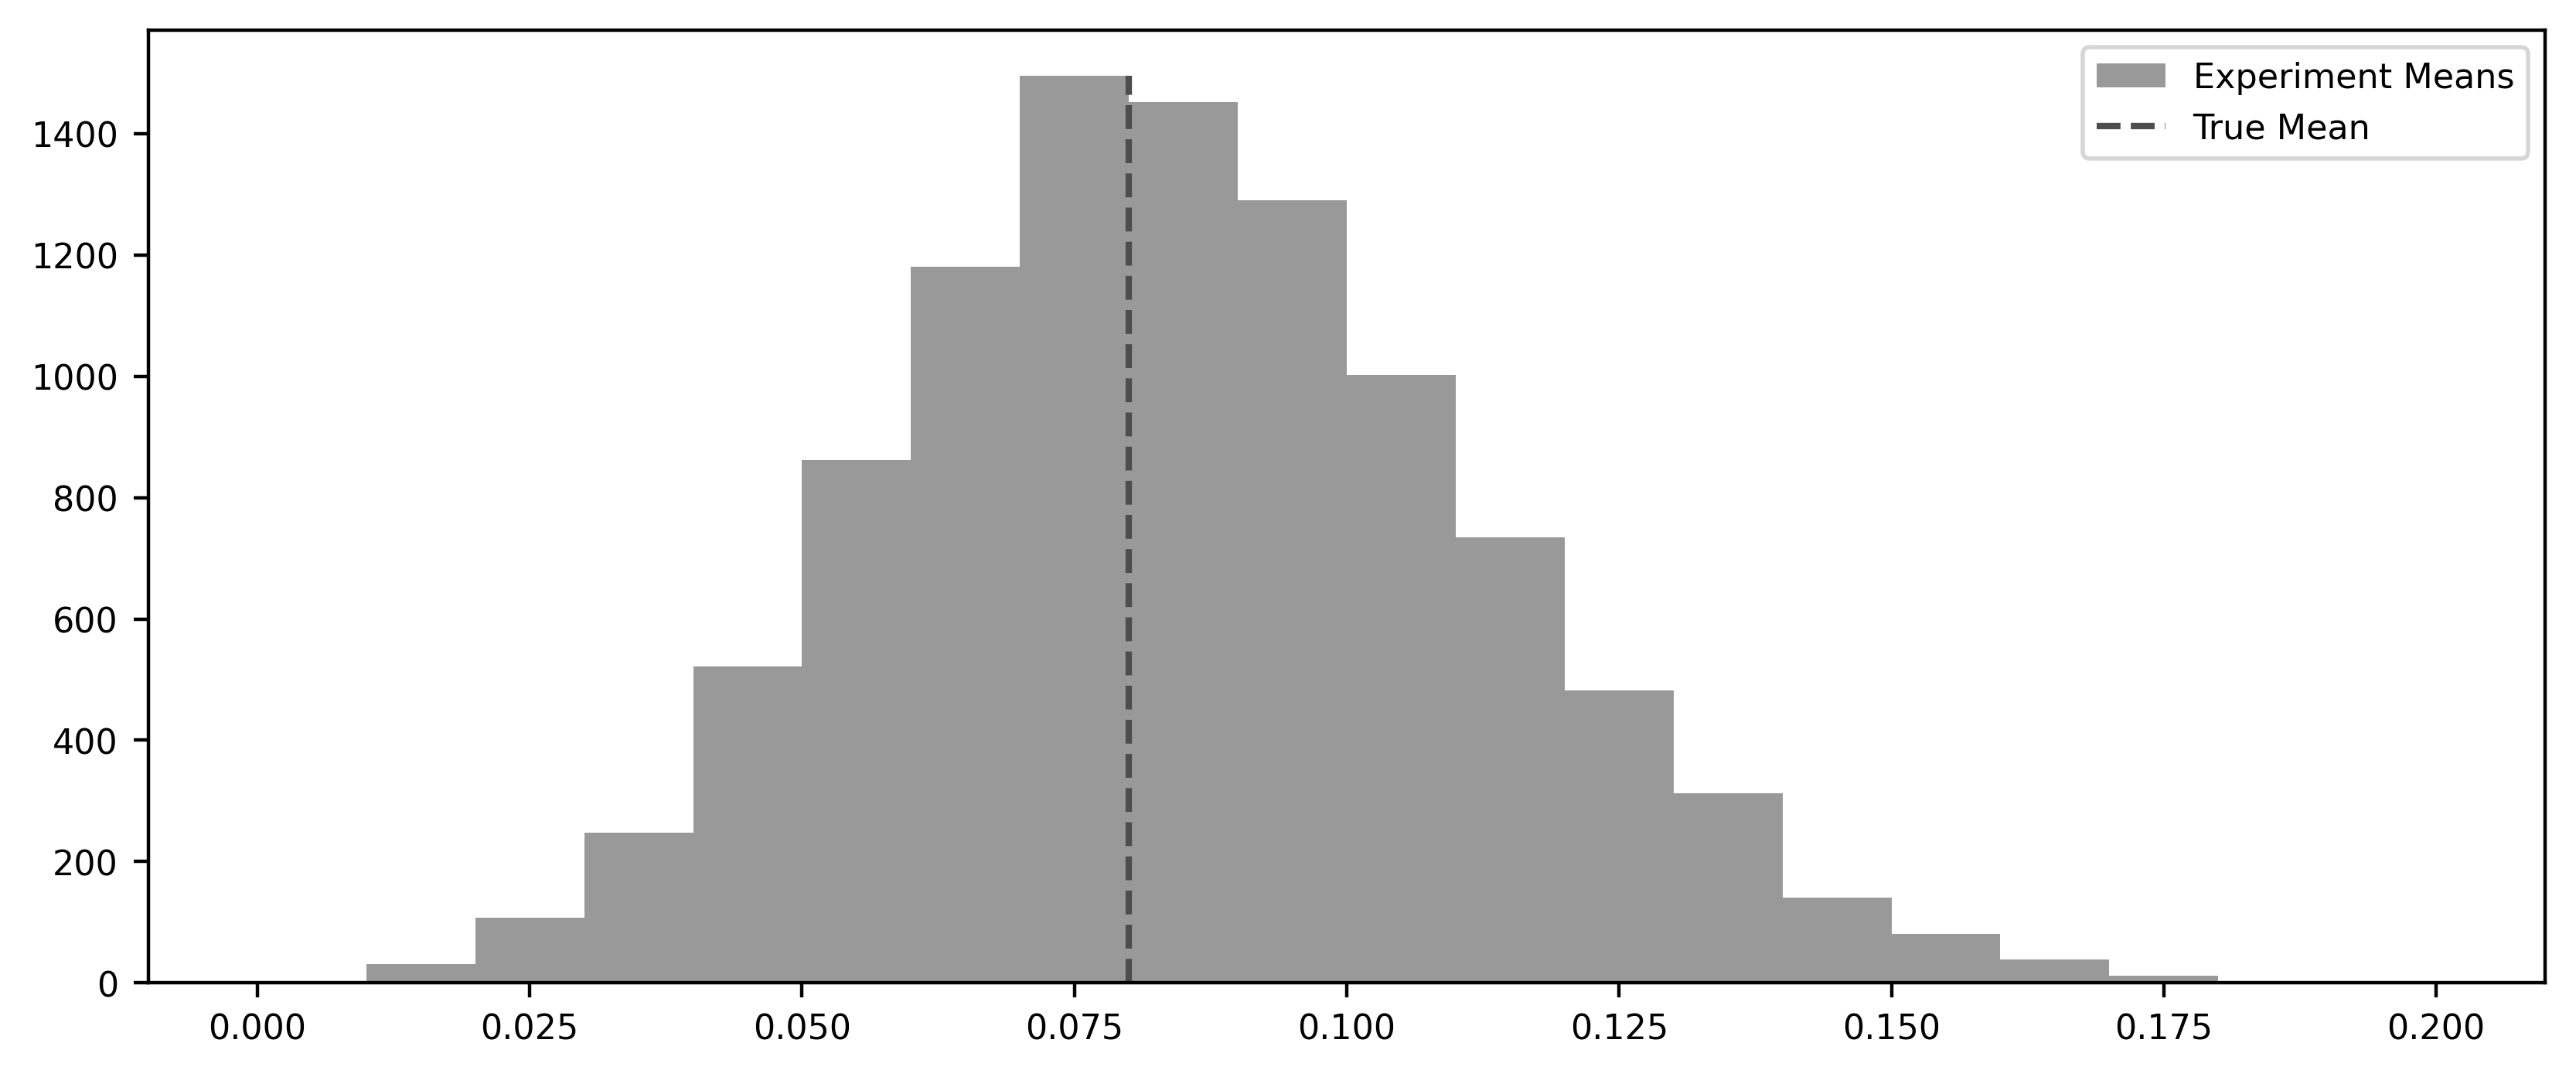

In [959]:
# distribution of sample means from multiple samples
plt.figure(figsize=(10,4))
freq, bins, img = plt.hist(experiments, bins=20, label='Experiment Means', color='0.6')
plt.vlines(conv_rate, ymin=0, ymax=freq.max(), # mark the true success rate, conv_rate 
           linestyles='dashed', label='True Mean', color='0.3')
plt.legend()

(array([92.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  8.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

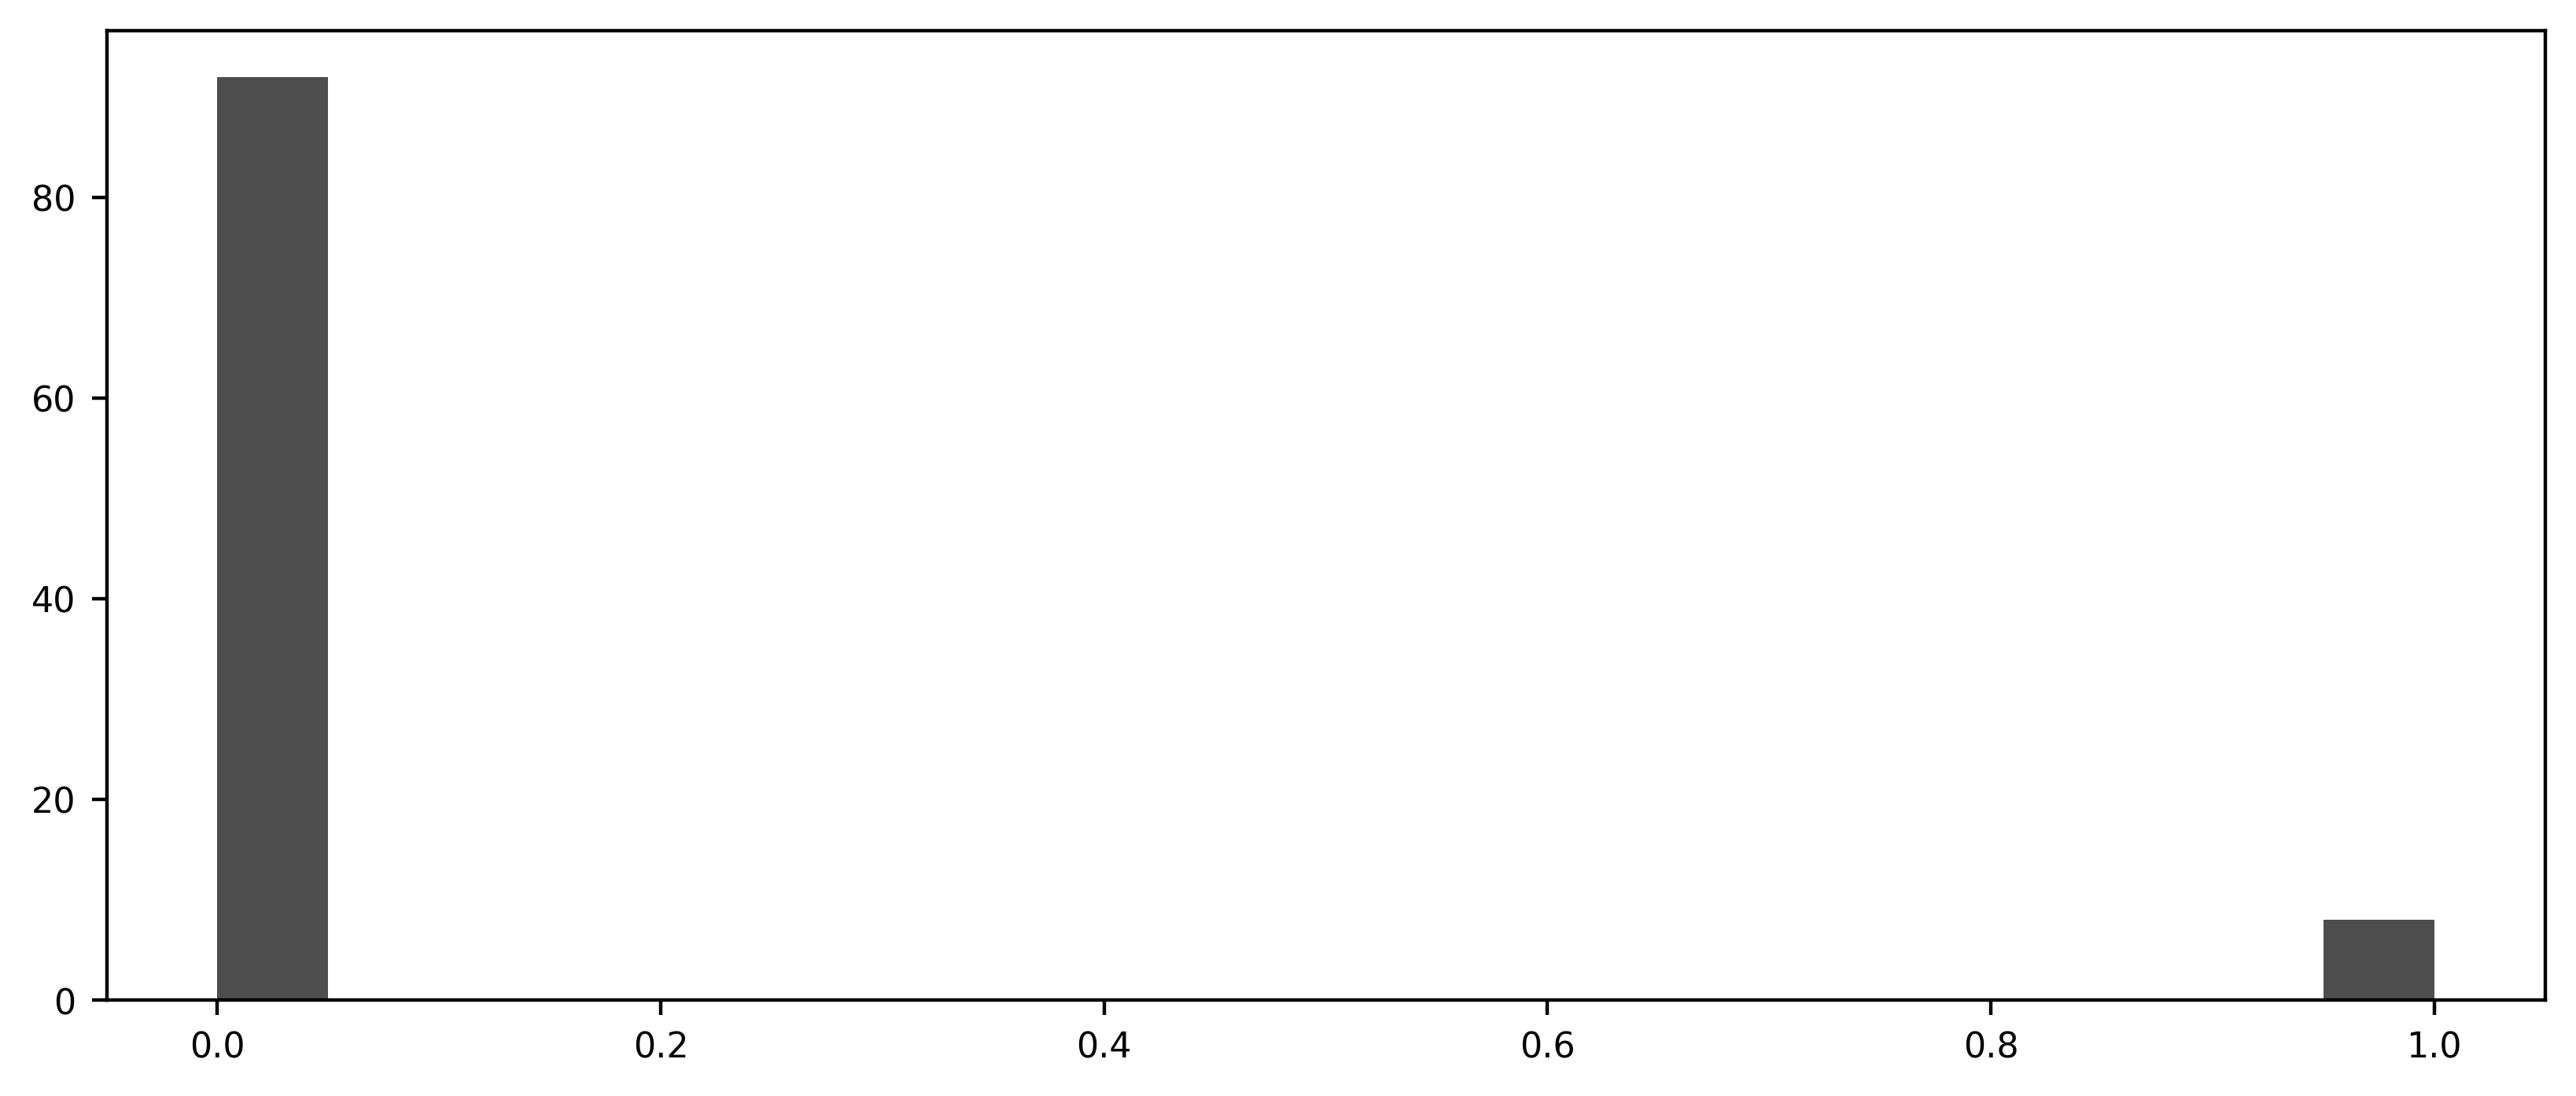

In [960]:
# plotting binomial collection of responses (bernoulli)
np.random.seed(42)
plt.figure(figsize=(10,4))
plt.hist(np.random.binomial(1, 0.08, 100), bins=20)

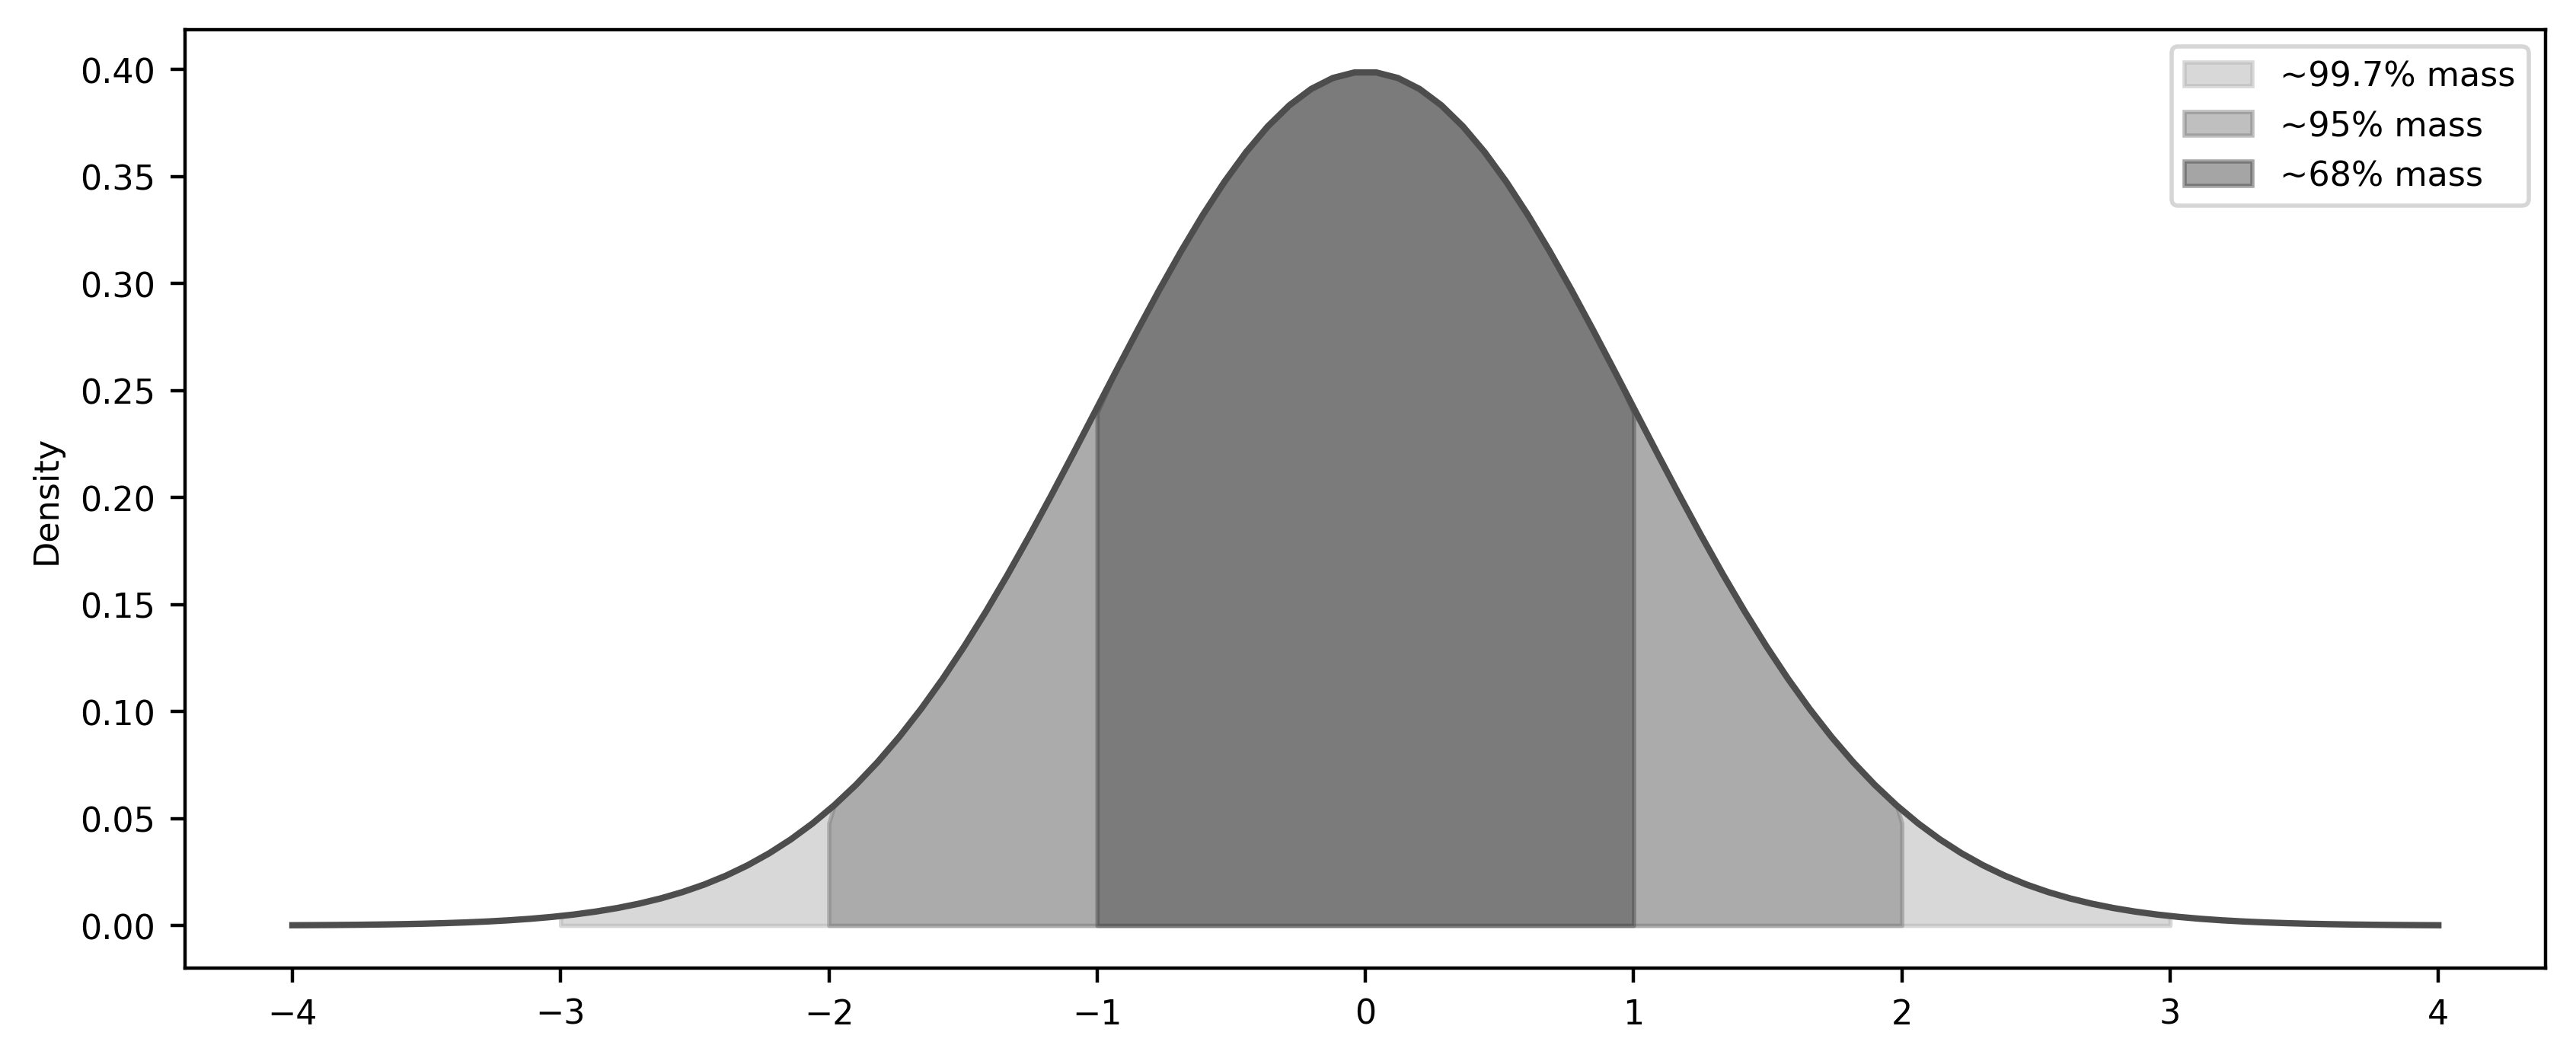

In [961]:
# standard normal confidence intervals
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, 0, 1)     # pdf at x of normal distribution of mean 0 and std 1 (standard normal)

plt.figure(figsize=(10,4))
plt.plot(x, y, linestyle='solid') # line plot of the interval against pdf values
plt.fill_between(x.clip(-3, +3), 0, y, alpha=0.5, label="~99.7% mass", color="C2") # array x.clip(min,max) 
plt.fill_between(x.clip(-2, +2), 0, y, alpha=0.5, label="~95% mass", color="C1")
plt.fill_between(x.clip(-1, +1), 0, y, alpha=0.5, label="~68% mass", color="C0")
plt.ylabel("Density")
plt.legend()

In [962]:
import scipy

scipy.stats.norm.pdf(np.linspace(-4, 4, 100)) # normal pdf of values default mean 0 default std 1

array([1.33830226e-04, 1.84295302e-04, 2.52138056e-04, 3.42709873e-04,
       4.62784614e-04, 6.20862299e-04, 8.27514755e-04, 1.09577221e-03,
       1.44154732e-03, 1.88408981e-03, 2.44646147e-03, 3.15601632e-03,
       4.04486639e-03, 5.15030799e-03, 6.51517825e-03, 8.18810653e-03,
       1.02236211e-02, 1.26820683e-02, 1.56292995e-02, 1.91360817e-02,
       2.32771927e-02, 2.81301641e-02, 3.37736510e-02, 4.02854146e-02,
       4.77399263e-02, 5.62056185e-02, 6.57418315e-02, 7.63955298e-02,
       8.81978860e-02, 1.01160853e-01, 1.15273870e-01, 1.30500851e-01,
       1.46777638e-01, 1.64010075e-01, 1.82072870e-01, 2.00809396e-01,
       2.20032535e-01, 2.39526659e-01, 2.59050772e-01, 2.78342808e-01,
       2.97125003e-01, 3.15110210e-01, 3.32008980e-01, 3.47537175e-01,
       3.61423830e-01, 3.73418974e-01, 3.83301094e-01, 3.90883931e-01,
       3.96022313e-01, 3.98616779e-01, 3.98616779e-01, 3.96022313e-01,
       3.90883931e-01, 3.83301094e-01, 3.73418974e-01, 3.61423830e-01,
      

In [963]:
# 95% confidence interval 
exp_se = short_email.sem()          # unbiased standard error for short email conversion rate distribution
exp_mu = short_email.mean()         # mean for short email conversion rate distribution
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)  # standard error is estimate of std of underlying process
print("95% CI for Short Email: ", ci) # distribution of means is approximately normal

95% CI for Short Email:  (0.06436609374091676, 0.18563390625908324)


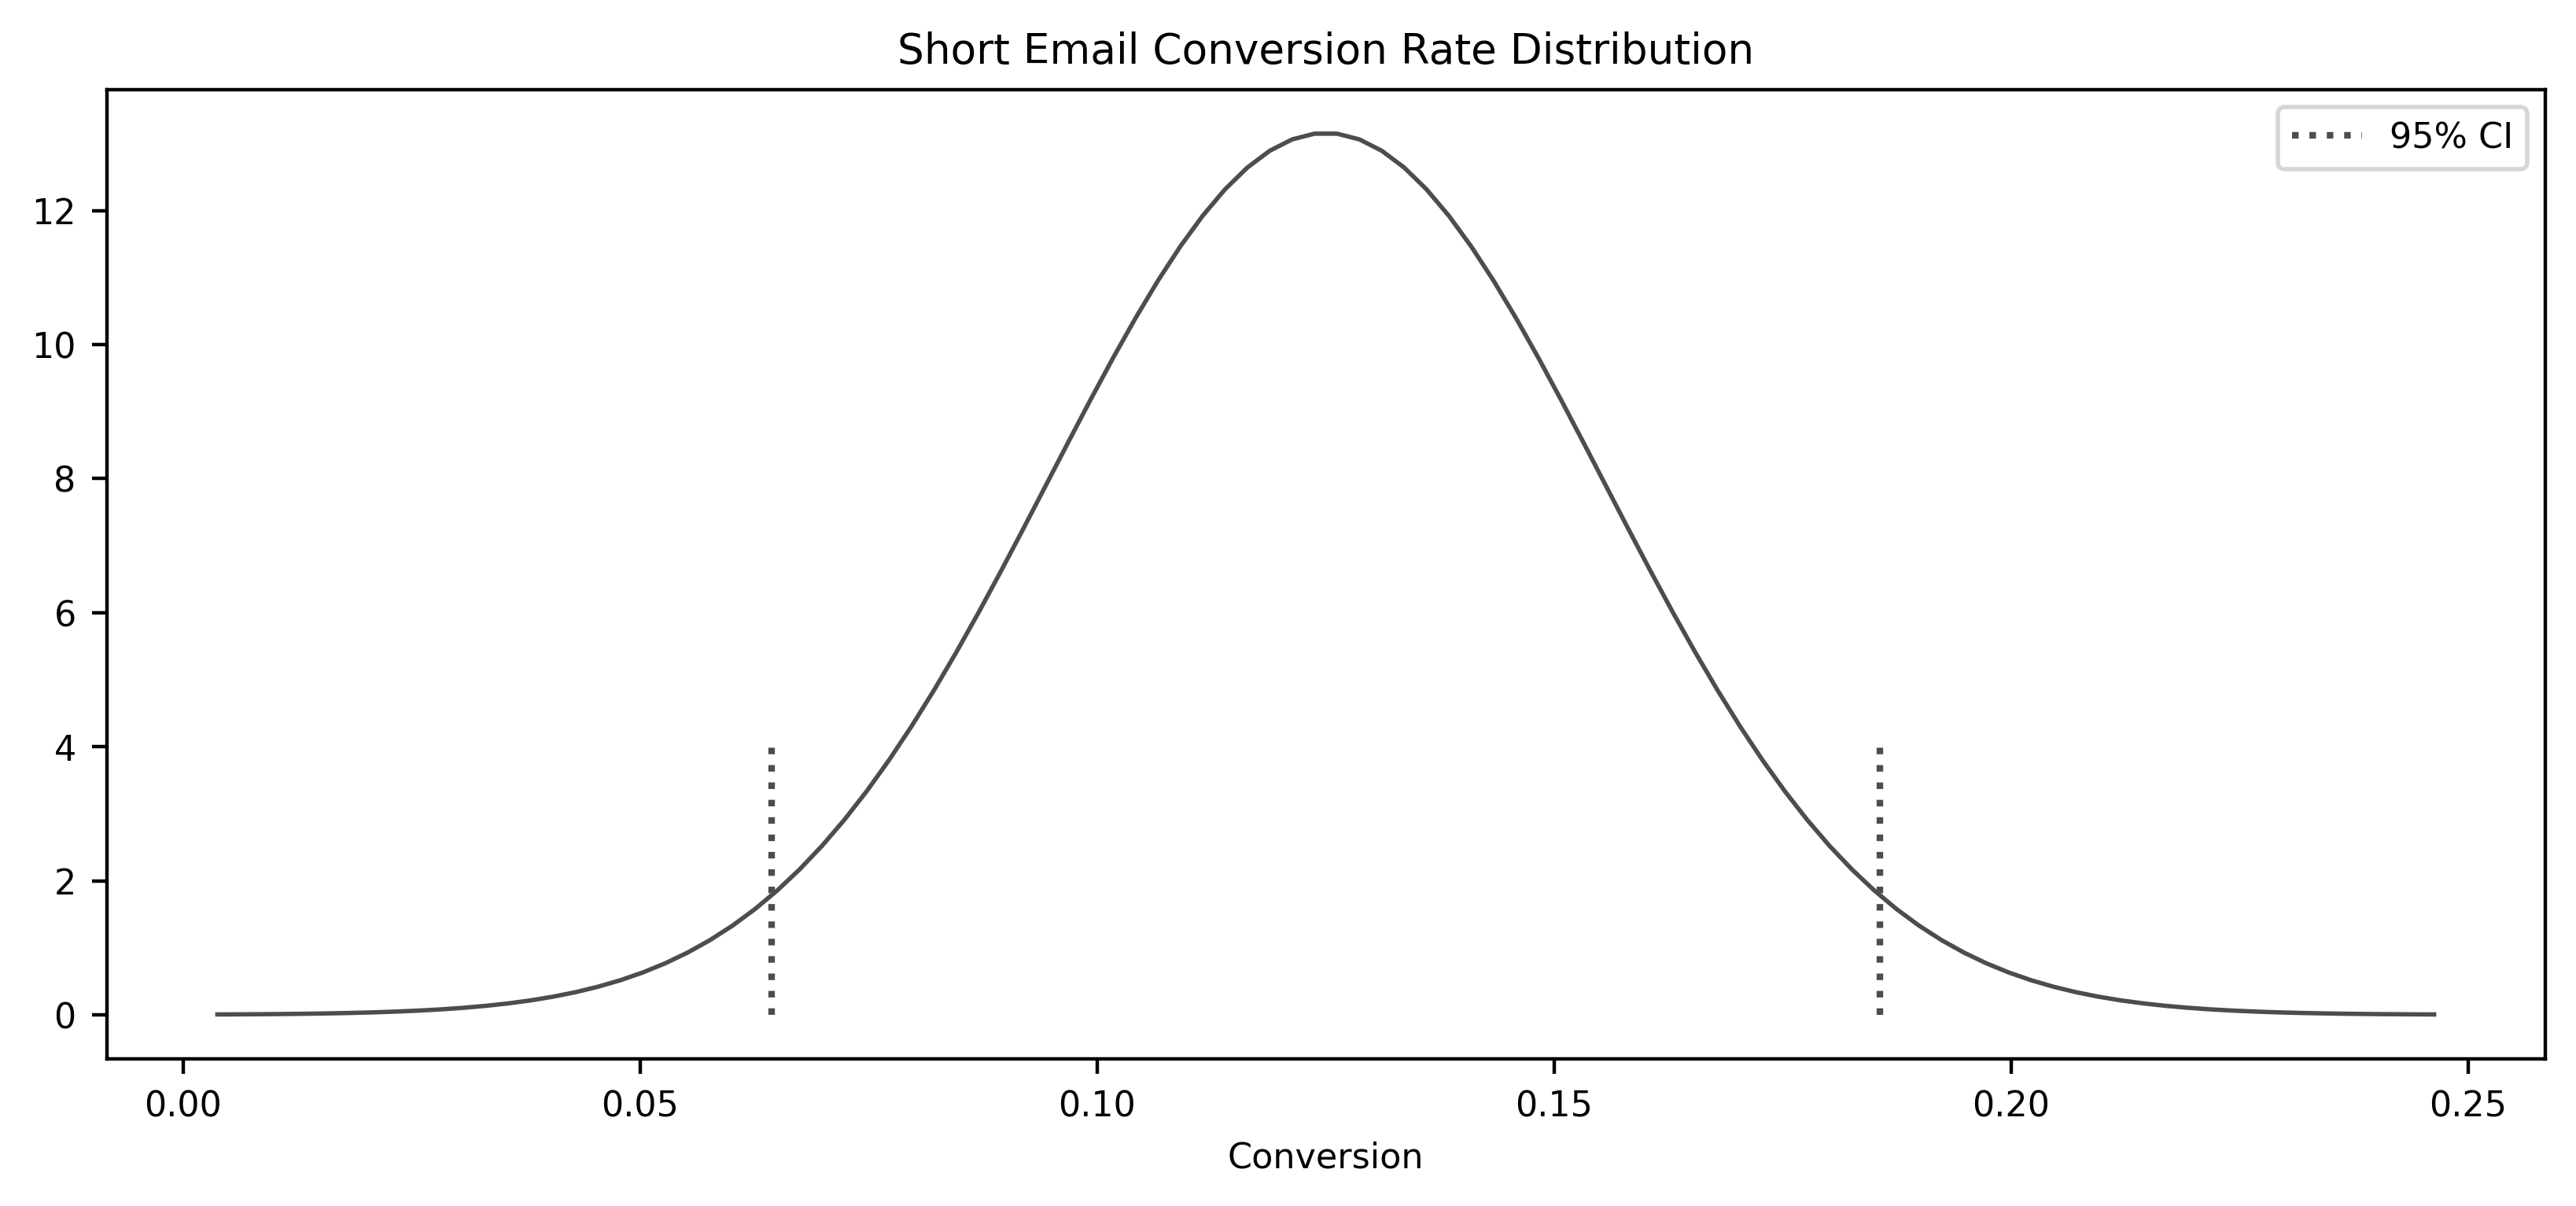

In [964]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)  # most of normal distribution is -4 to +4
y = stats.norm.pdf(x, exp_mu, exp_se) # pdf of x vals for normal dist of mean exp_mu, and std exp_se

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=1)
plt.vlines(ci[1], ymin=0, ymax=4, ls='dotted')  # vertical line at upper bound of 95% confidence interval
plt.vlines(ci[0], ymin=0, ymax=4, ls='dotted', label="95% CI") # label lower bound for single label in legend
plt.xlabel('Conversion')
plt.title('Short Email Conversion Rate Distribution')
plt.legend()

In [965]:
# scipy ppf to find factor corresponding to confidence interval (confidence = mu +- factor*standard error)
z = np.abs(stats.norm.ppf((1-.99)/2))   # 99% CI factor by inverse CDF (cdf for standard normal x-val)
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)    # 99% confidence interval
ci

2.5758293035489004


(0.04690870373460816, 0.20309129626539185)

In [966]:
stats.norm.ppf((1-.99)/2) # input is cdf, output is num of standard deviations above/below mean to said cdf

-2.5758293035489004

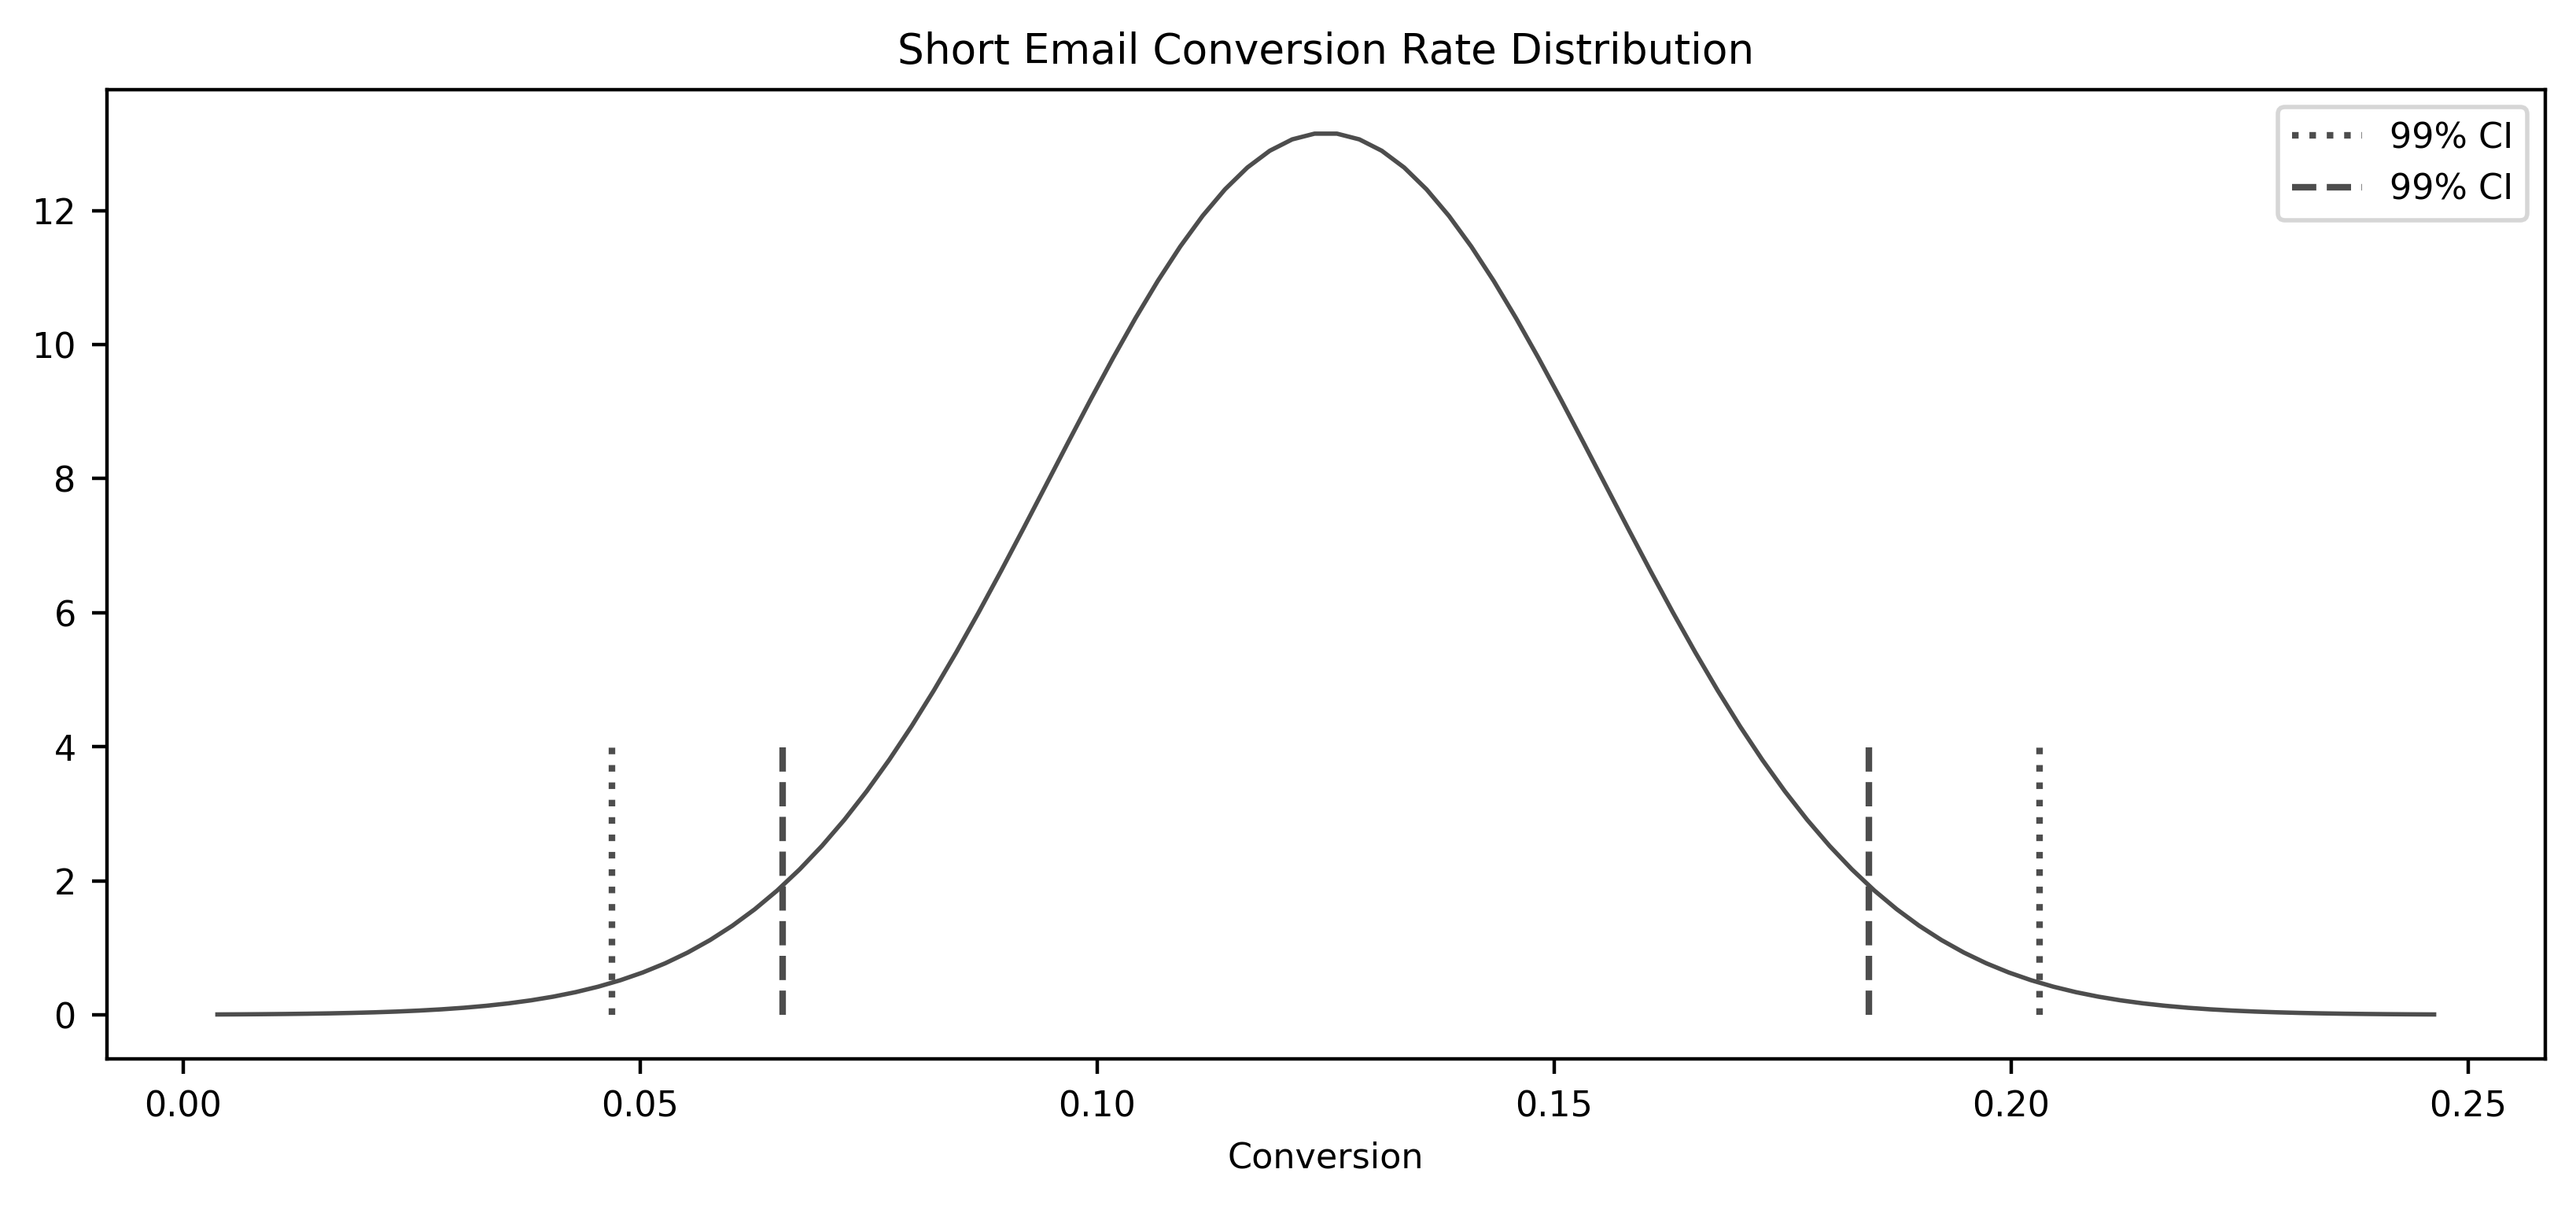

In [967]:
# Visualize both 95% CI and 99% CI for short_email distribution of sample mean
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)  # pdf of

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=1)
plt.vlines(ci[1], ymin=0, ymax=4, ls='dotted')
plt.vlines(ci[0], ymin=0, ymax=4, ls='dotted', label='99% CI')

ci_95 = (exp_mu - 1.96*exp_se, exp_mu + 1.96*exp_se)                # confidence interval

plt.vlines(ci_95[1], ymin=0, ymax=4, ls='dashed')
plt.vlines(ci_95[0], ymin=0, ymax=4, ls='dashed', label='99% CI')
plt.xlabel("Conversion")
plt.title('Short Email Conversion Rate Distribution')
plt.legend()

In [968]:
# 95% CI for conversion rate associated with other treatment groups
def ci(y: pd.Series):
    return (y.mean() - 2 * y.sem(),  y.mean() + 2 * y.sem()) # for normal distributon within 2 stds is 95% ci

print("95% CI for Short Email: ", ci(short_email))
print("95% CI for Long Email: ", ci(long_email))
print("95% CI for No Email: ", ci(no_email))

95% CI for Short Email:  (0.06436609374091676, 0.18563390625908324)
95% CI for Long Email:  (0.01115382234126202, 0.09893792077800403)
95% CI for No Email:  (0.0006919679286838468, 0.08441441505003955)


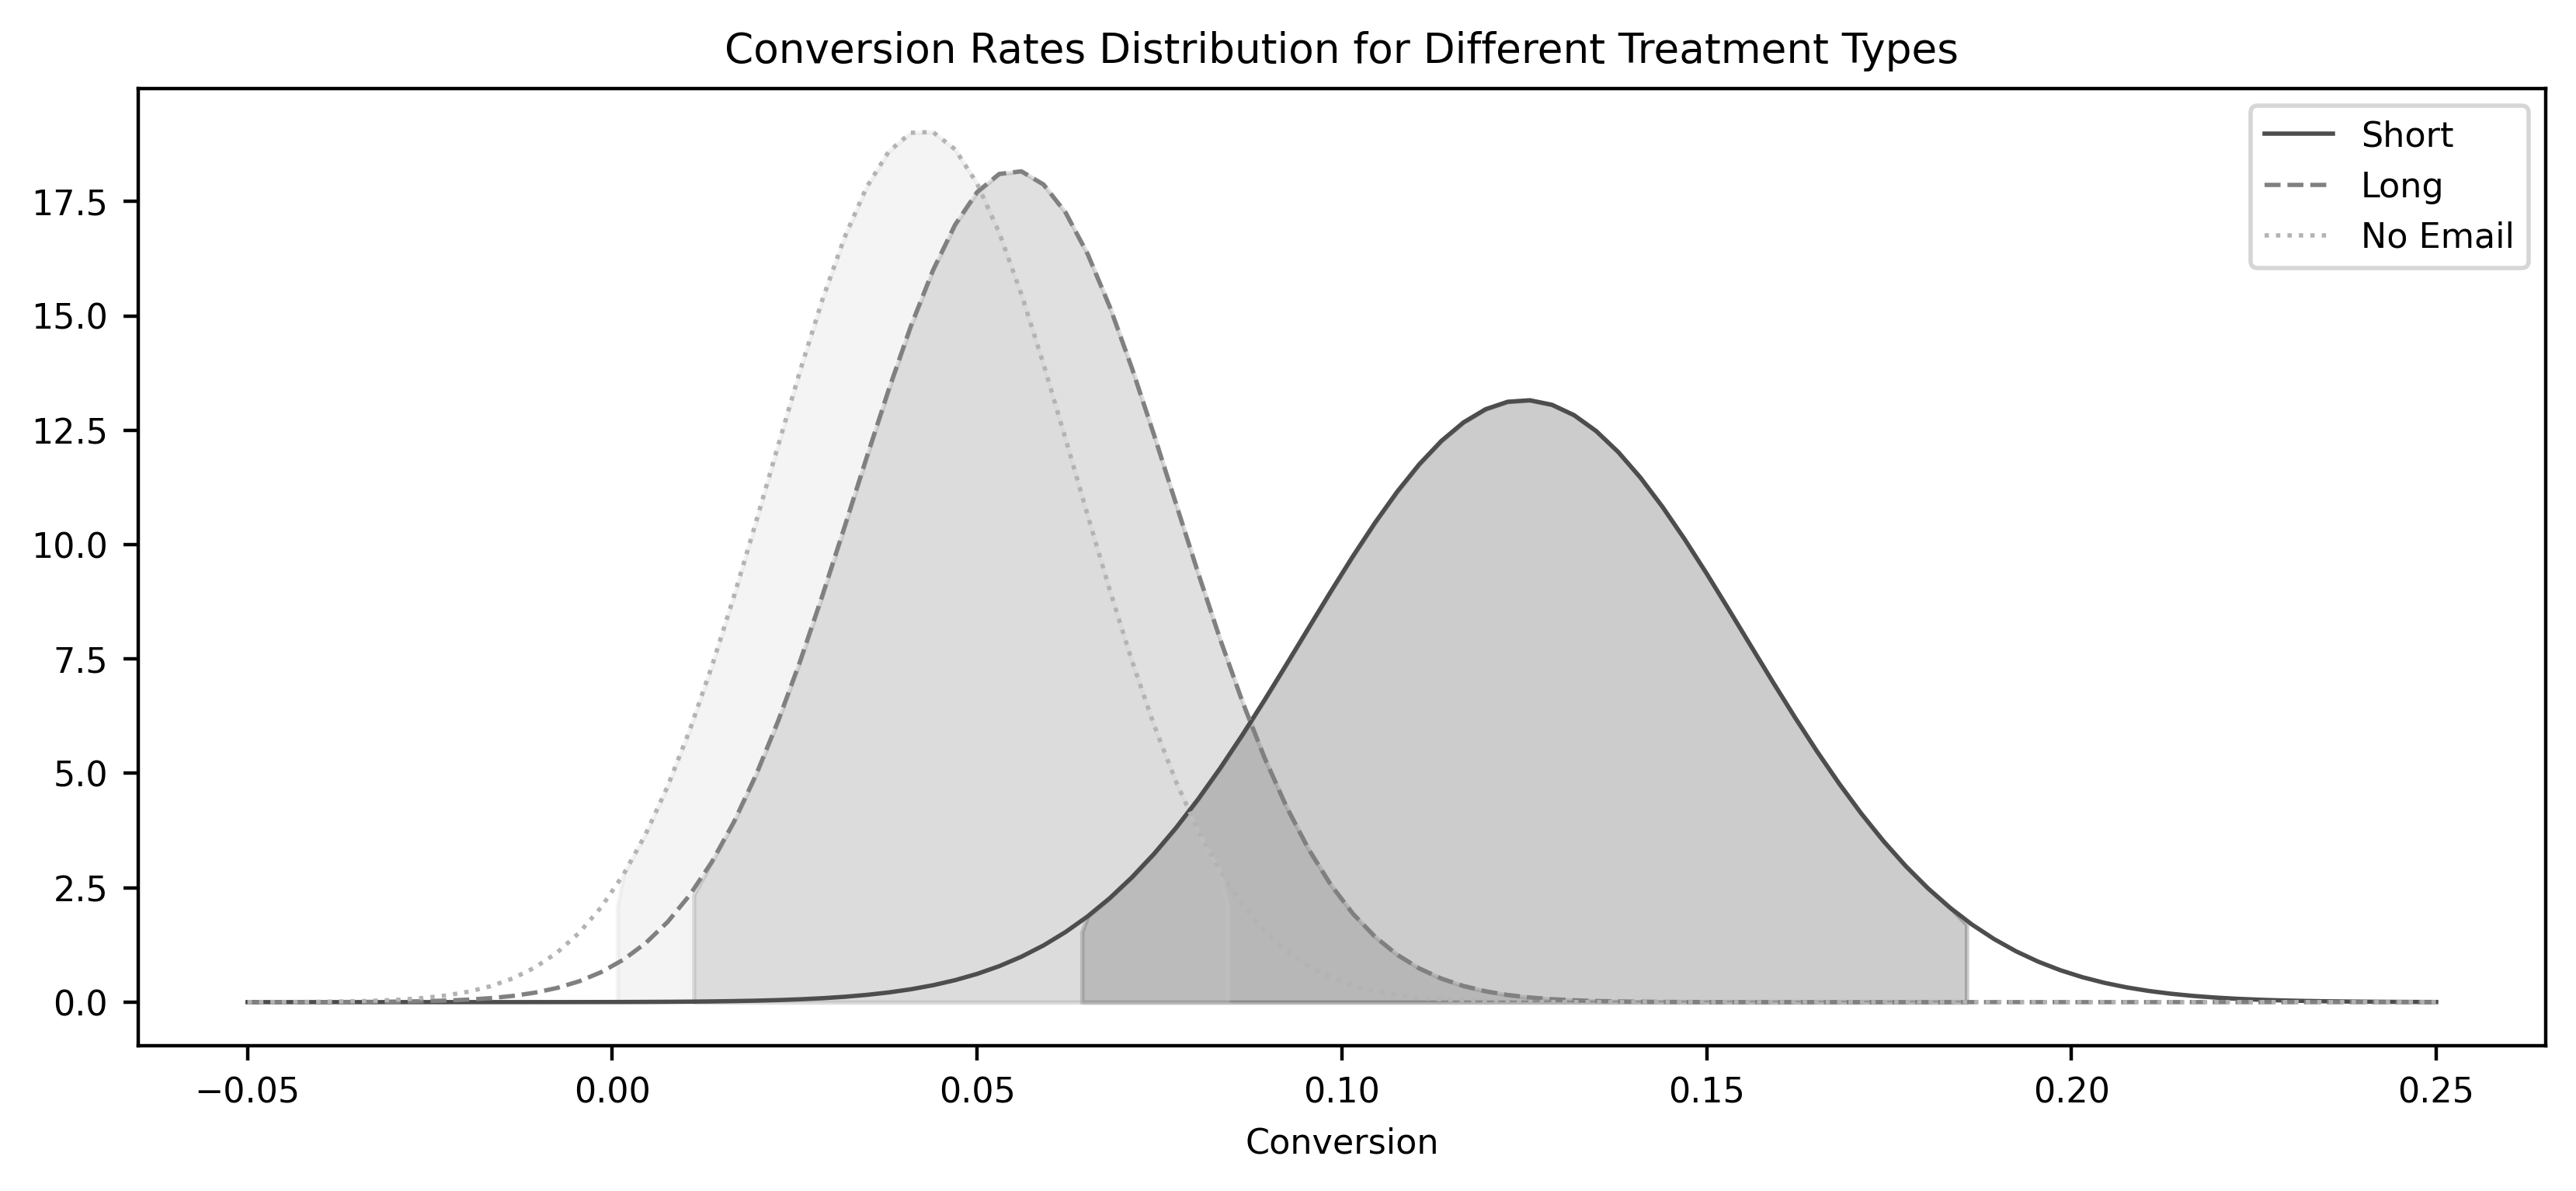

In [969]:
plt.figure(figsize=(10,4))

x = np.linspace(-0.05, .25, 100)    # x-values, possible conversion rates from confidence intervals above

short_dist = stats.norm.pdf(x, short_email.mean(), short_email.sem())   # pdf values are not probabilities
plt.plot(x, short_dist, lw=1, label="Short", linestyle=linestyle[0])
plt.fill_between(x.clip(ci(short_email)[0], ci(short_email)[1]), # xvals= x clipped btn min,max
                 0, short_dist, alpha=0.2, color="0.0") # y0, y1 ie (xvals, y0), (xvals, y1) fill polygons


long_dist = stats.norm.pdf(x, long_email.mean(), long_email.sem())      # pdf values 
plt.plot(x, long_dist, lw=1, label="Long", linestyle=linestyle[1])
plt.fill_between(x.clip(ci(long_email)[0], ci(short_email)[1]), 
                 0, long_dist, alpha=0.2, color="0.4") # fill between 95% confidence interval


no_email_dist = stats.norm.pdf(x, no_email.mean(), no_email.sem())      # pdf values
plt.plot(x, no_email_dist, lw=1, label="No Email", linestyle=linestyle[2])
plt.fill_between(x.clip(ci(no_email)[0], ci(no_email)[1]), 
                 0, no_email_dist, alpha=0.2, color="0.8   ")


plt.xlabel('Conversion')
plt.title('Conversion Rates Distribution for Different Treatment Types')
plt.legend()

#### Hypothesis Testing

The sum or difference of two independent normal distribution is also a normal distribution. The resulting mean will be the sum or difference between the two distributions, while the variance will always be the sum of the variances.

$N(\mu_1, \sigma_1^2) - N(\mu_2, \sigma_2^2) = N(\mu_1 - \mu_2, \sigma_1^2 + \sigma_2^2)$

$N(\mu_1, \sigma_1^2) + N(\mu_2, \sigma_2^2) = N(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)$

In other words,

$\mu_{diff} = \mu_1 - \mu_2$

$SE_{diff} = \sqrt{SE_1^2+SE_2^2}$

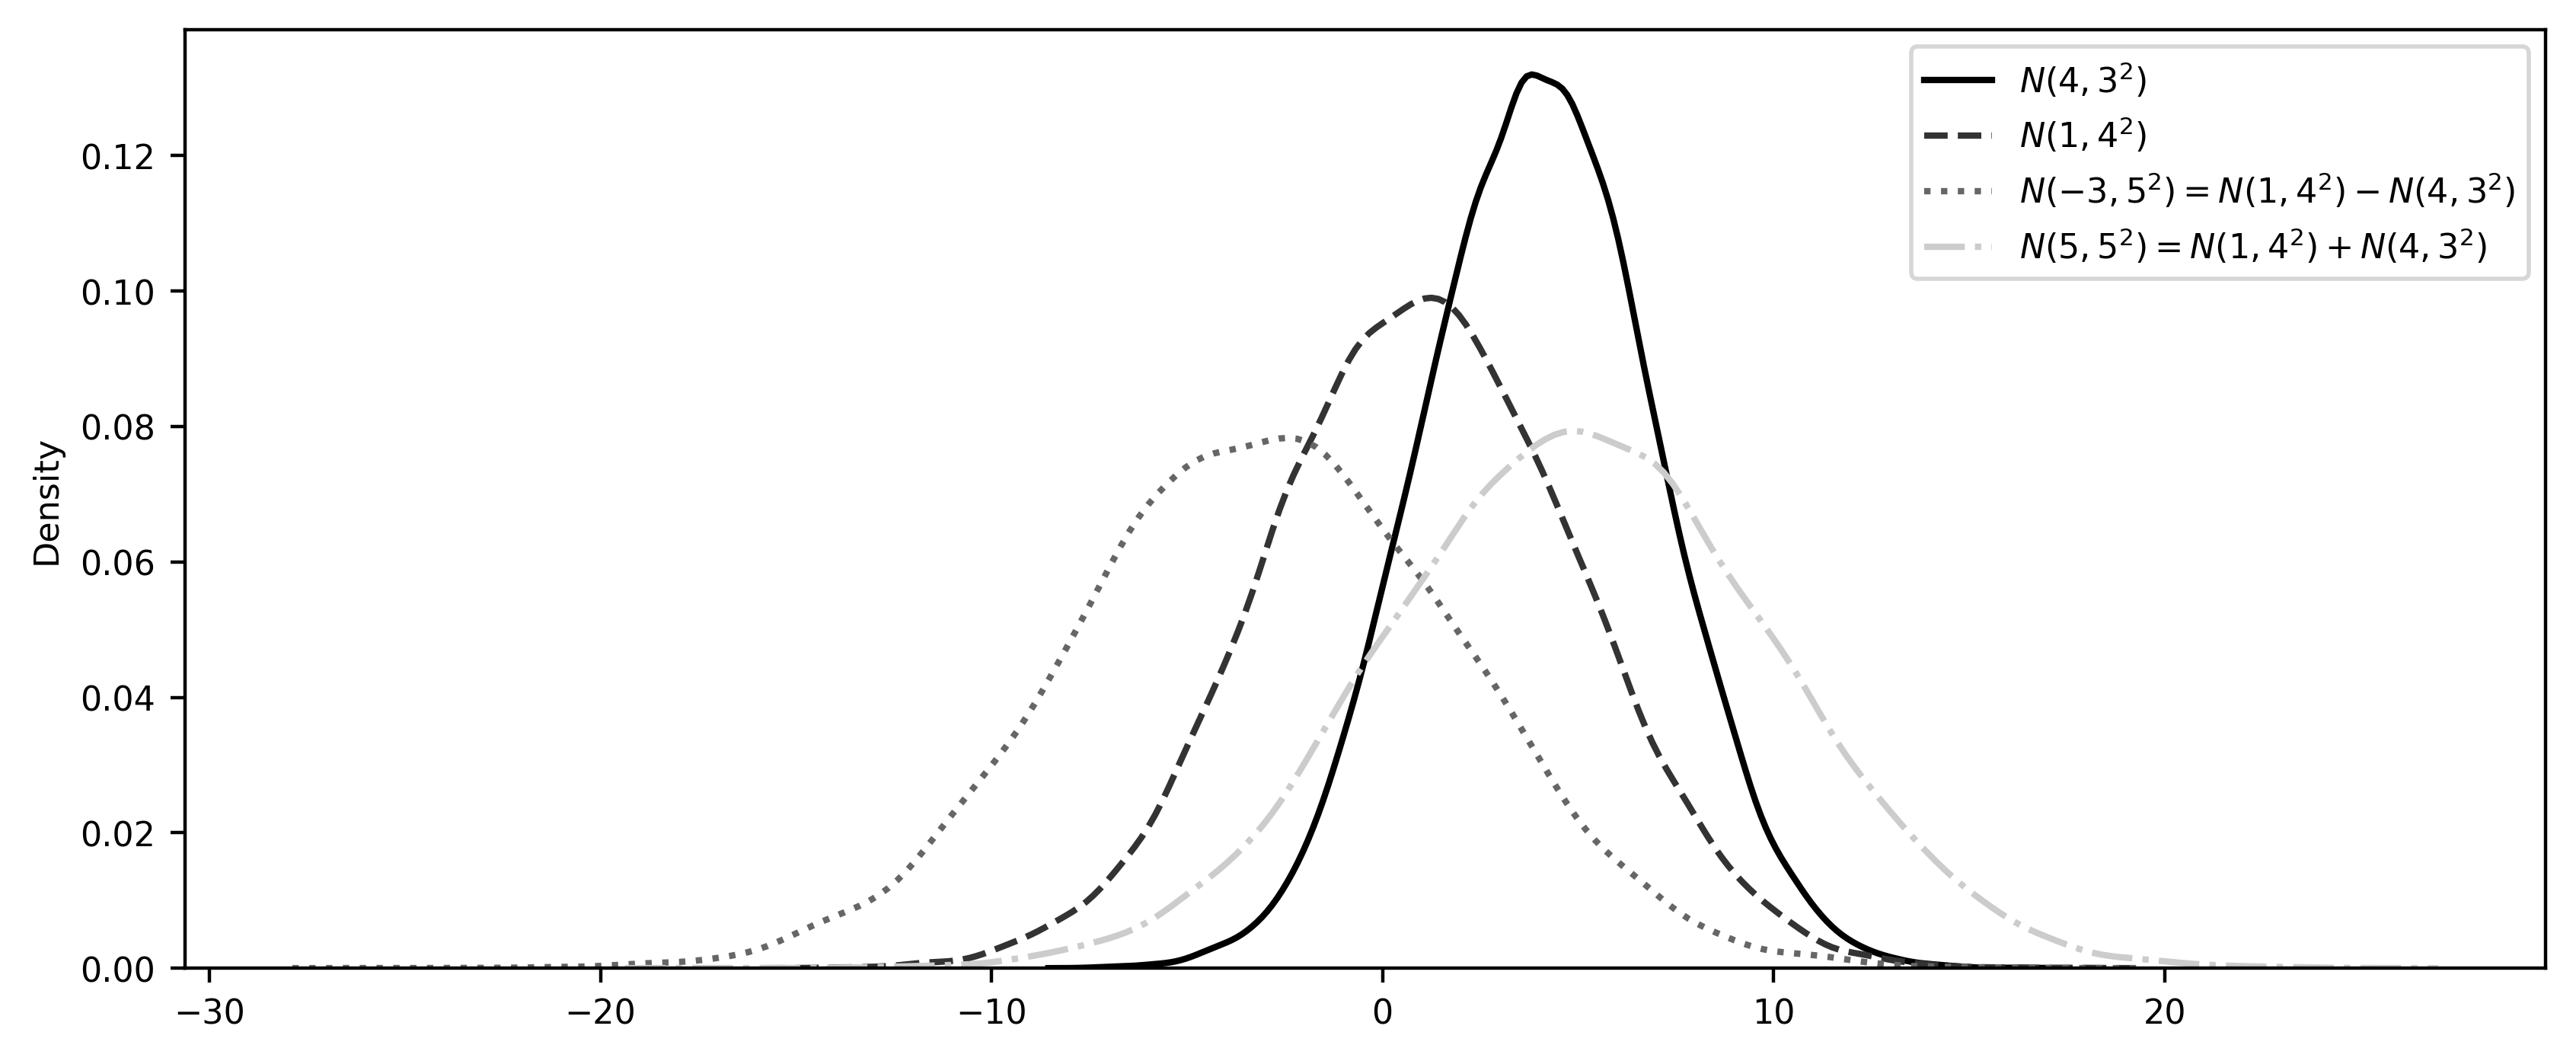

In [970]:
np.random.seed(123)

n1 = np.random.normal(4, 3, 30000)       # random sample from normal distribution of mean,std, size
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1            # subtract corresponding points from both distributions (they have the same size)
n_sum = n2 + n1

plt.figure(figsize=(10,4))
sns.distplot(n1, hist=False, label="$N(4,3^2)$", color="0.0", kde_kws={"linestyle": linestyle[0]})
sns.distplot(n2, hist=False, label="$N(1,4^2)$", color="0.2", kde_kws={"linestyle": linestyle[1]})
sns.distplot(n_diff, hist=False, label="$N(-3,5^2) = N(1,4^2)- N(4,3^2) $", 
             color="0.4", kde_kws={"linestyle": linestyle[2]})
sns.distplot(n_sum, hist=False, label="$N(5,5^2) = N(1,4^2)+ N(4,3^2) $", 
             color="0.8", kde_kws={"linestyle": linestyle[3]})
plt.legend()


In [971]:
# the actual factor for the 95% interval
np.abs(stats.norm.ppf((1-.95)/2)) # number of standard deviations above/below mean of standard normal

1.959963984540054

Since the distribution of sample means is a normal distribution, then we can take the difference between two distributions of sample means and still have a normal distributions. To compare the short email campaign to the no email option, we can construct the distribution for the difference in means between the two. We know that the mean of the resulting normal distribution will be the difference the mean of the two distribution of sample means which is simply the conversion rates. The variance of the resulting normal distribution will be the sum of the variance of the distribution of means ie squaring up the standard error of the mean. With the mean and variance of the difference between the short and no email sample means, we can construct the distribution of the difference of sample means and get the confidence intervals. Taking the square root of the variance of the distribution of the difference of sample means would give the standard error of the distribution of the difference of sample means.

In [972]:
diff_mu = short_email.mean() - no_email.mean()  # distribution mean of difference of sample means
diff_se = np.sqrt(no_email.sem()**2 + short_email.sem()**2) #distribution variance of difference of sample means

ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se) # 95% confidence interval of difference of sample means
print(f"95% CI for the difference (short email - no email):\n{ci}")

95% CI for the difference (short email - no email):
(0.01023980847439844, 0.15465380854687816)


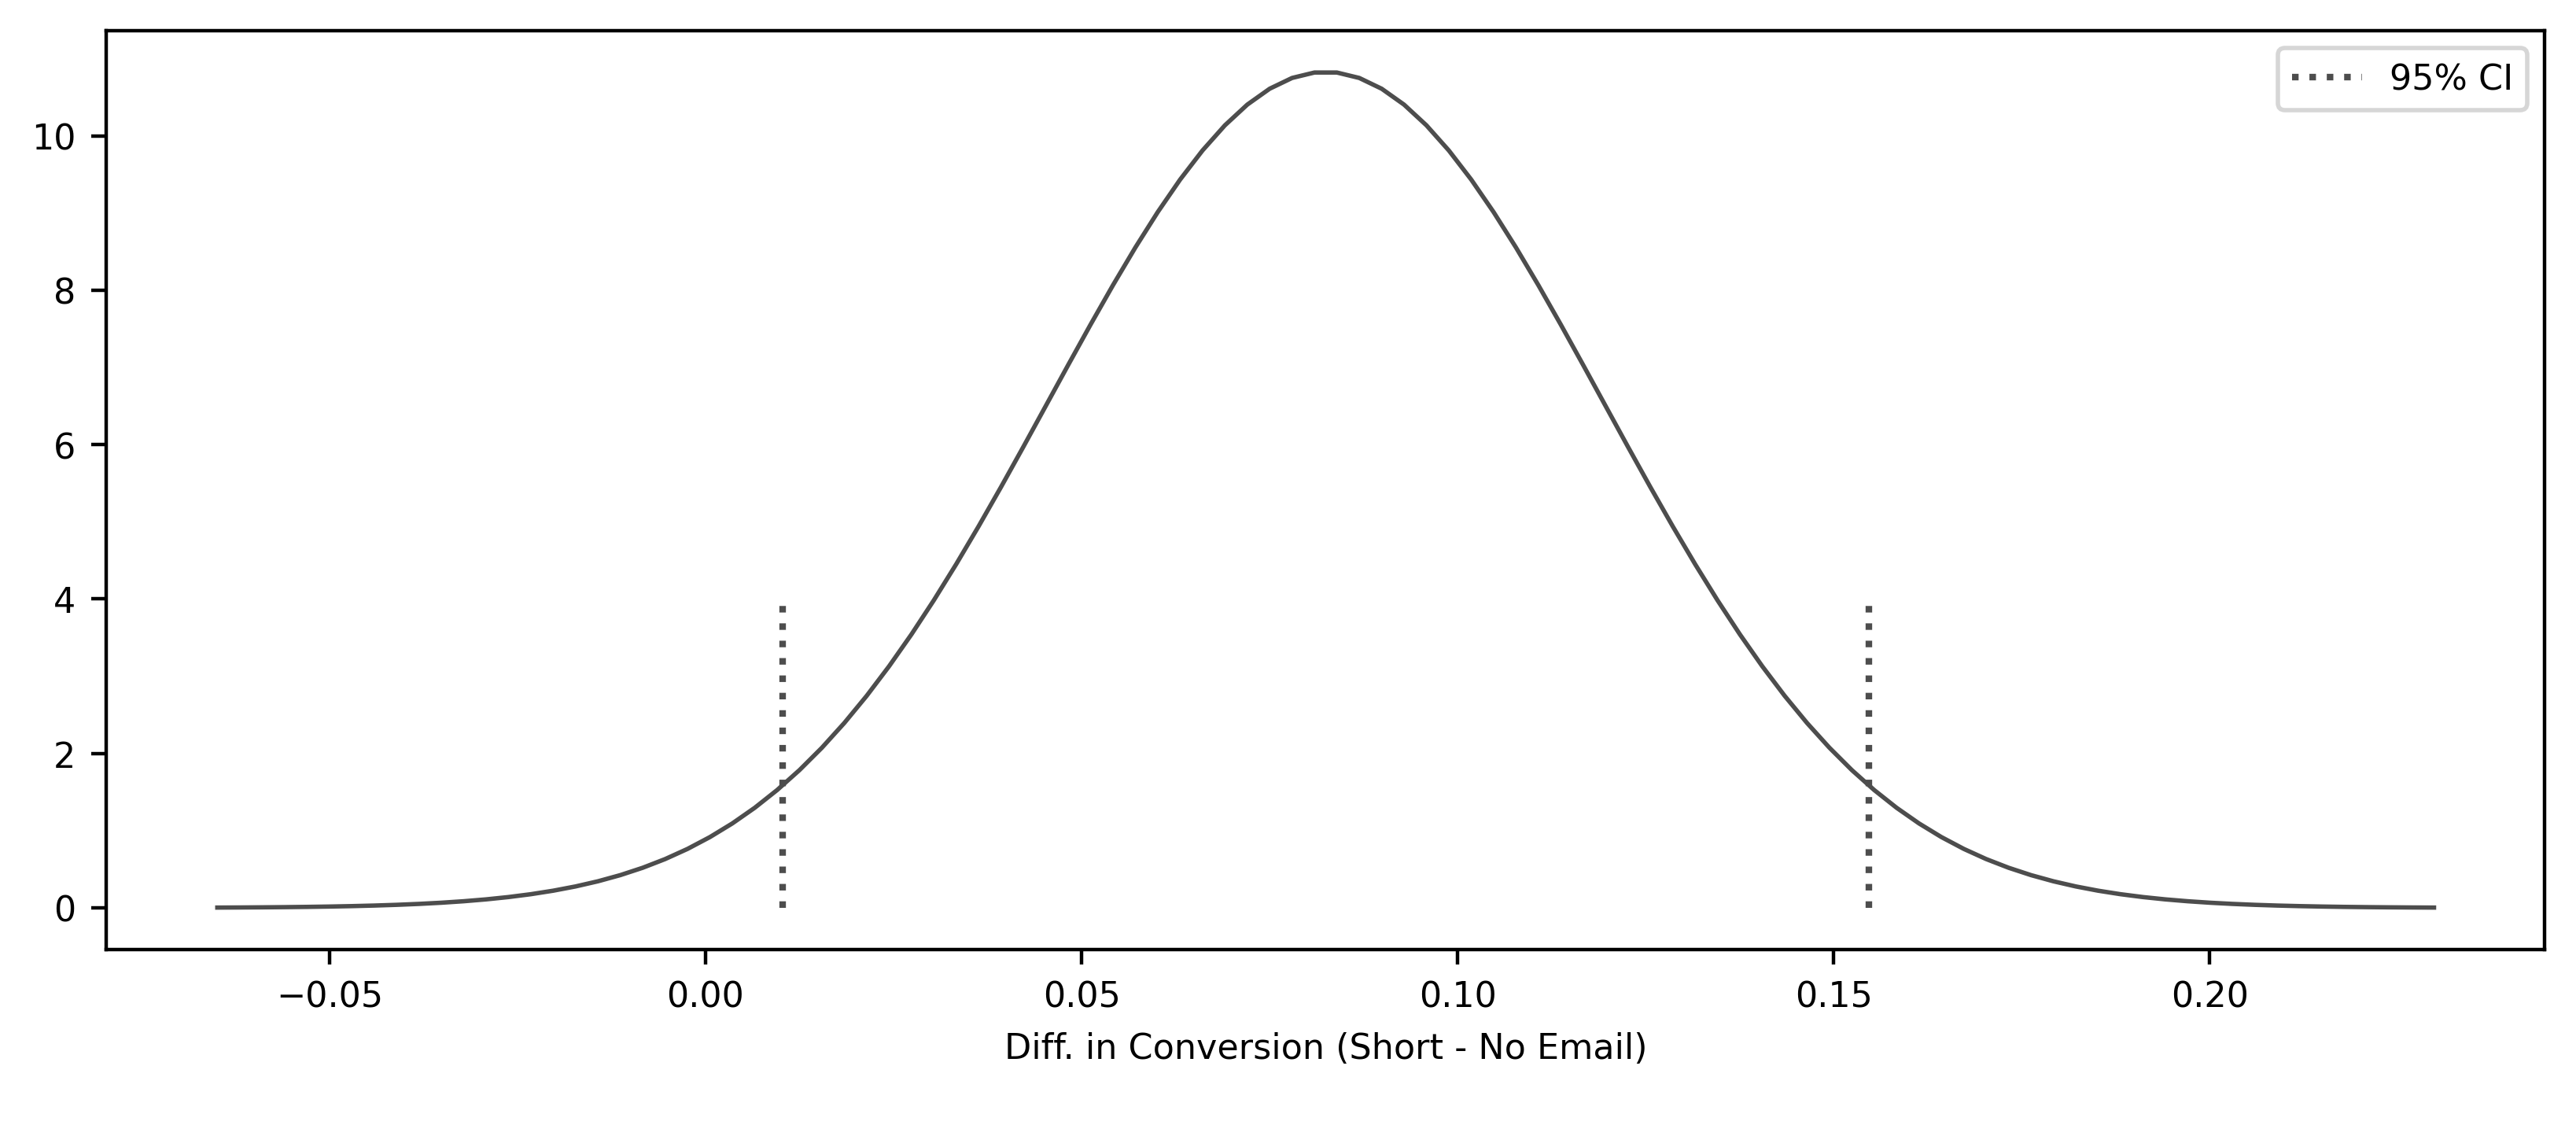

In [973]:
x = np.linspace(diff_mu -  4*diff_se, diff_mu + 4*diff_se, 100) # range of difference of mean values
y = stats.norm.pdf(x, diff_mu, diff_se)  # pdf of normal dist of mean diff_mu, and std diff_se

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=1)
plt.vlines(ci[1], ymin=0, ymax=4, ls='dotted')
plt.vlines(ci[0], ymin=0, ymax=4, ls='dotted', label="95% CI")
plt.xlabel("Diff. in Conversion (Short - No Email)\n")
plt.legend()
plt.subplots_adjust(bottom=0.15)

#### Null Hypothesis

$H_0:Conversion_{no\_email}=Conversion_{short\_email}= \mu_1 - \mu_2 = 0$ 

This null hypothesis states that there is no difference in conversion rates between a short email and no email at all. To verify how likely it is to observe the difference between conversion rates if the null hypothesis were true, we use the confidence intervals. If the 95% confidence interval of the difference does not contain zero, and the null hypothesis states that the difference is zero, then the probability of seeing such a result would be too low, if the null hypothesis were true. Hence, we can reject the null hypothesis with 95% confidence.

We can also define other types of null hypothesis. Say the marketing team will only roll out emails if the lift in conversion is 1%, then our null hypothesis will be "the difference in conversion rate is 1%". To test this hypothesis, we shift the confidence interval by subtracting 1% from the difference in means. If this 95% CI is also above zero, you can also reject this other null hypothesis. 

$(\mu_1 - \mu_2) - H_0$ where $H_0$ is the value defined by your null hypothesis (0%, 1% etc).

In [974]:
# Shifting the CI
diff_mu_shifted = short_email.mean() - no_email.mean() - 0.01  # a lift of 1% is required 
diff_se = np.sqrt(no_email.sem()**2 + short_email.sem()**2) # note standard error is squared for variance

ci = (diff_mu_shifted - 1.96*diff_se, diff_mu_shifted + 1.96*diff_se)
print(f"95% CI 1% difference between (short email - no email):\n{ci}")

95% CI 1% difference between (short email - no email):
(0.00023980847439844521, 0.14465380854687815)


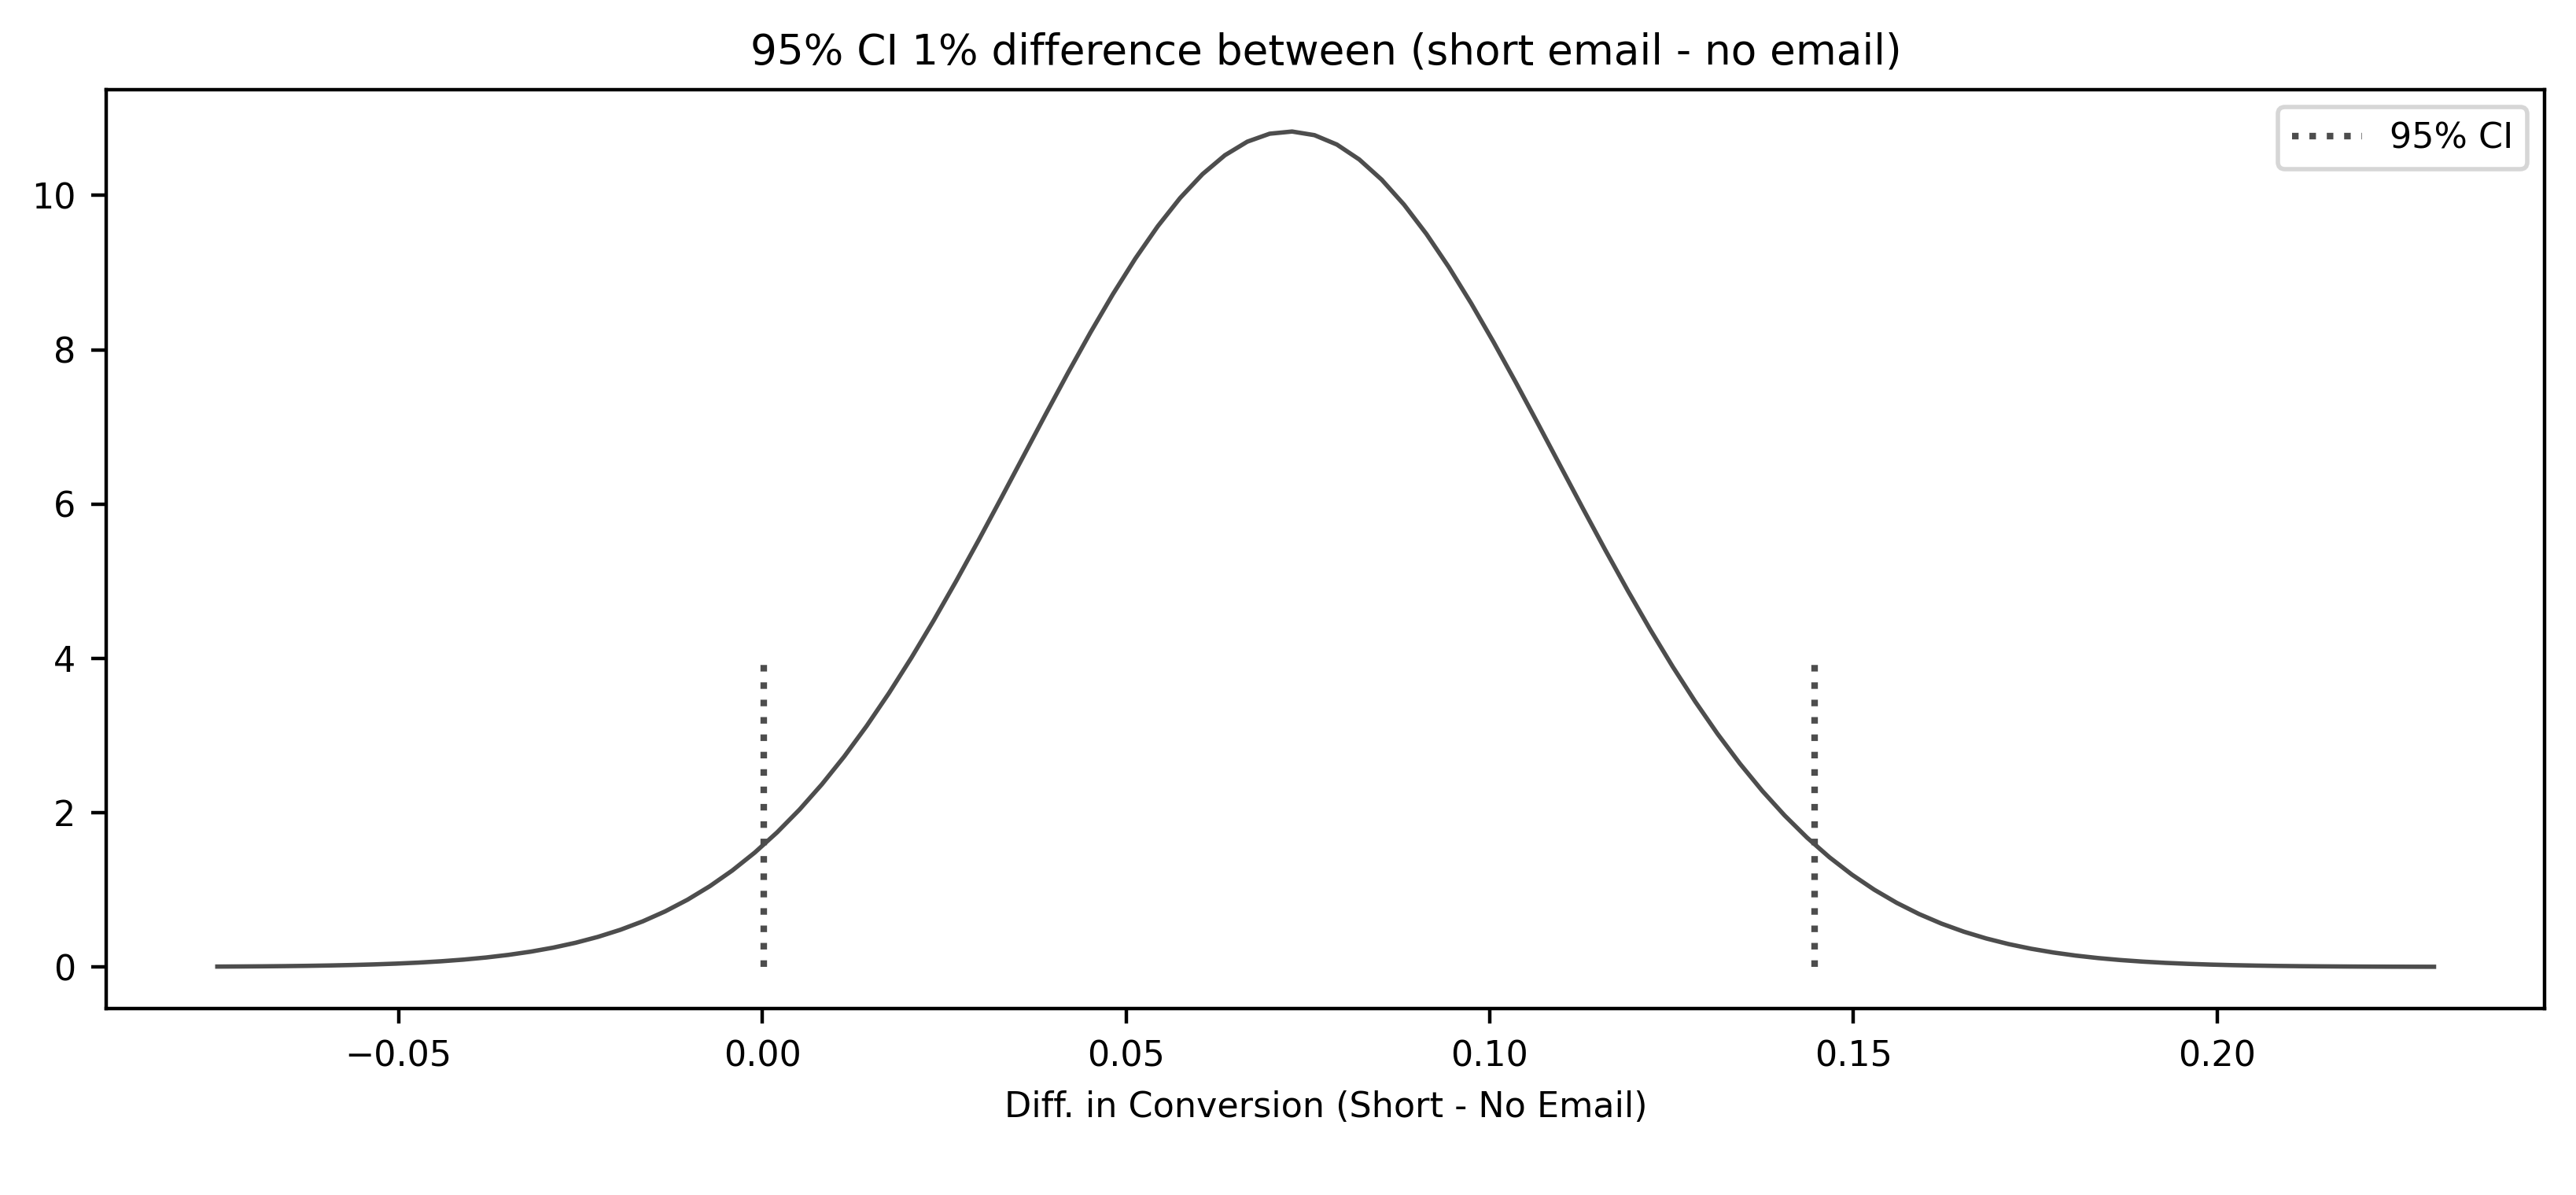

In [975]:
x = np.linspace(diff_mu_shifted -  4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu_shifted, diff_se)

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=1)
plt.vlines(ci[1], ymin=0, ymax=4, ls='dotted')
plt.vlines(ci[0], ymin=0, ymax=4, ls='dotted', label="95% CI")
plt.xlabel("Diff. in Conversion (Short - No Email)\n")
plt.title("95% CI 1% difference between (short email - no email)")
plt.legend()
plt.subplots_adjust(bottom=0.15)

#### Test Statistic

Besides confidence intervals, we can reject the null hypothesis in terms of a test statistic. Such statistics are often constructed such that higher values point toward rejection of the null. One such test statistics is the t-statistic. It is defined by normalizing the distribution that gives rise to the confidence interval.

$t_{\Delta} = \frac{\mu_{\Delta} - H_0}{SE_{\Delta}} = \frac{(\mu_1 - \mu_2) - H_0}{\sqrt{\sigma_1^2/n_1+\sigma_2^2/n_2}}$ where $H_0$ is the value defined by your null hypothesis. 

Since t-statistic is normally distributed under the null, we compare it to the standard normal distribution to identify the corresponding confidence interval factor. If the t-statistic of the difference distribution (that includes any required lift/difference) is 2.96, we know that its outside the 95% confidence interval of the standard normal since the 95% confidence interval of the standard normal ends at 1.96. We can also compute 
probability value from the t-statistic  known as the p-value.

The p-value is the probability of obtaining test results at least as extreme as the results actually observed duing the test, assuming the null hypothesis is correct. Put differently, the p-value is the probability of seeing such data, if the null hypothesis were true. The p-value is $P(data|H_0)$ and not $P(H_0|data)$. The p-value frees you from having to specify a confidence level, like 95% or 99%. If you wish to report a confidence interval, from the p-value, you know precisely at which confidence your test will pass or fail. For instance, with a p-value of 0.025, you'll have significance to the 2.5% level. So, while the 95% CI for the difference will not contain zero, the 99% CI will. This p-value also means there is only a 2.5% chance of observing this extreme test statistic, if the difference was truly zero.

In [976]:
# Calculating the t-statistic
t_stat = (diff_mu - 0) / diff_se    # hypothesis of no effect ie H_0 (t-stat is just convert to standard normal)
t_stat                              # greater than 1.96 (standard normal) so reject null hypothesis

2.2379512318715364

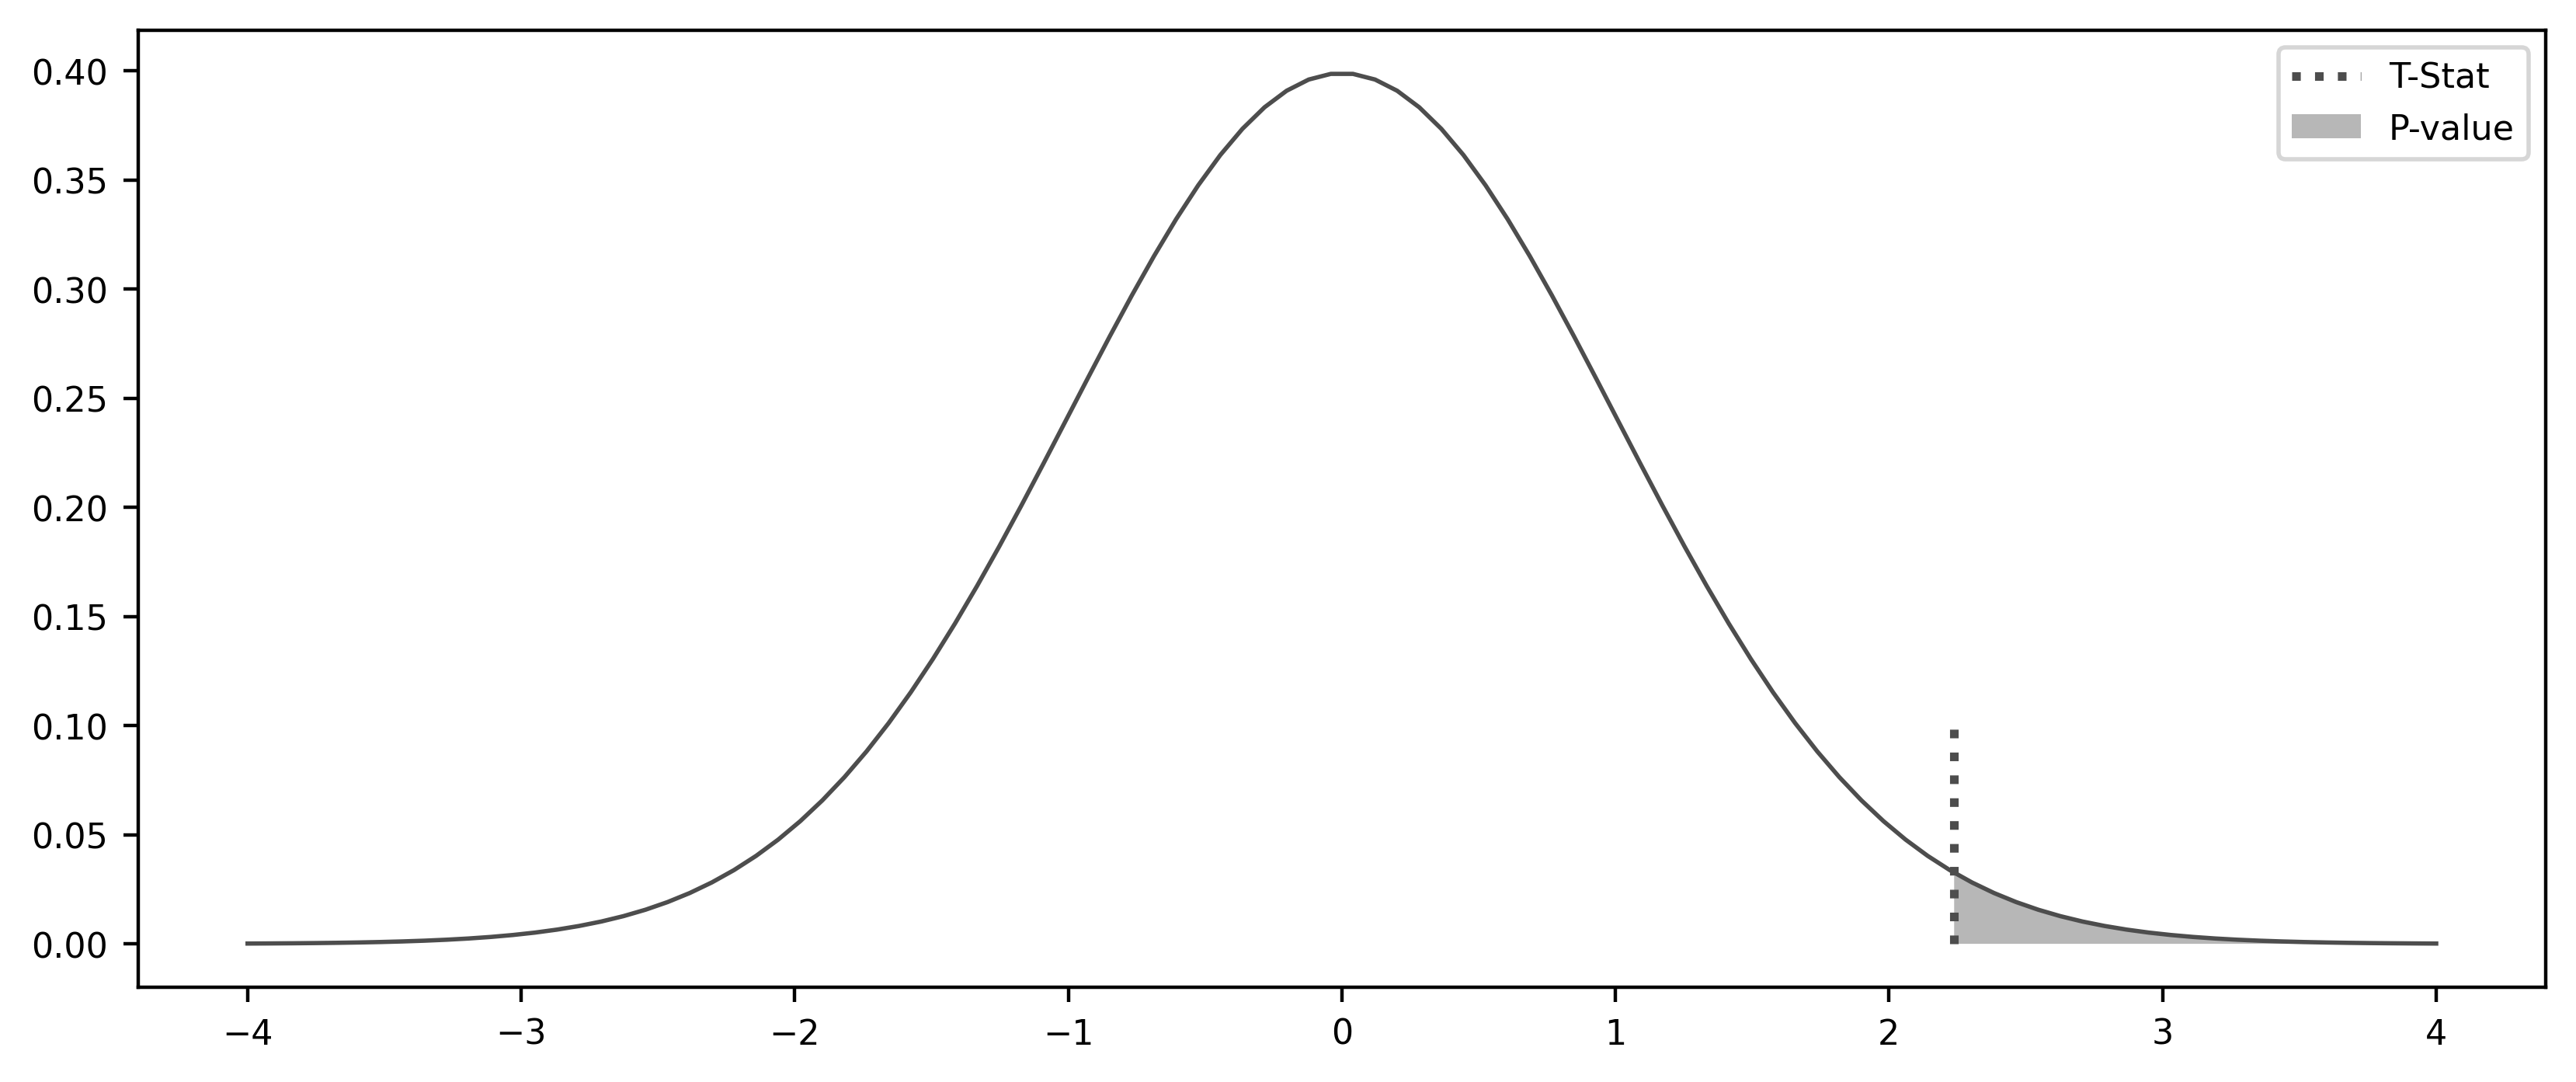

In [977]:
x = np.linspace(-4, 4, 100)         # possible x values of the standard normal
y = stats.norm.pdf(x, 0, 1)         # pdf of x values of standard normal

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=1)
plt.vlines(t_stat, ymin=0, ymax=0.1, ls='dotted', label='T-Stat', lw=2)
plt.fill_between(x.clip(t_stat), 0, y, alpha=0.4, label="P-value") # x.clip(min=t_stat,max=None)
plt.legend()

In [978]:
print("p-value: ", (1 - stats.norm.cdf(t_stat))*2) # two-sided p-value, the cdf of the t-stat times 2

p-value:  0.025224235562152142


#### Power 

Significance level, $\alpha$, is the chance of rejecting the null when it is true- committing a Type I error (false positive). The significance  level, $\alpha$, is also the Type I error rate. To achieve a certain significance level, construct a $1-\alpha$ confidence interval around your estimate. The industry standard for significance level, $\alpha$  is 5% (false positive rate), so a 95% confidence interval is constructed around estimates.

Power is closely related to statistical significance. While $\alpha$ is the chance of rejecting the null hypothesis when it is actually true, power $(1-\beta)$ is the chance of rejecting the null when it is false.  Power is the chance of correctly rejecting the null or $(1-\beta)$, with $\beta$ being the probability of not rejecting the null when it is false (probability of the false negative, Type II error, so $\beta$ is the Type II error rate).

The industry standard for power is 80%, meaning you only have a 20% ($\beta=0.2$) chance of not rejecting the null, when it is indeed false. You need to get the lower end of the 95% CI above zero, 80% of the time. The lower end of the 95% confidence interval also follows a normal distribution and has a variance equal to SE but a mean of $\delta - 1.96SE$. In order to have $\delta - 1.96SE > 0$, 80% of the time, you need the difference to be $1.96SE + 0.84SE$ away from zero: 1.96 to give you the 95% CI and 0.84 so that the lower end of that interval falls above zero,  80% of the time.

Another way to look at this is to realize that $\delta$ - the difference between the null hypothesis and the observed estimate - must be detectable if the null is false. With $\alpha=5\%$ and $1-\beta=80\%$, the detectable effect  is given by $1.96SE+0.84SE = 2.8SE$. For example, if you want to craft a cross-sell email experiment where you want to detect a 1% difference, you must have a sample size that gives you at least 1%=2.8SE. Since $SE_{\Delta}= \sqrt{SE_1^2+SE_2^2}$, if we assume variance of both treated and control is the same then $SE_{\Delta}= \sqrt{SE_1^2+SE_2^2} = \sqrt{2\sigma^2/n}= \sigma\sqrt{2/n}$. To determine the sample size of each variant in a test if you want 80% power and 95% significance, $\delta = 2.8\sigma\sqrt{2/n}$, therefore $n≅ 16\sigma^2/
\delta^2$.

In [983]:
stats.norm.cdf(0.84) # distribution of lower end of 95% CI also follows a normal distribution

0.7995458067395503

In [985]:
np.ceil(16* no_email.std()**2/0.01)  # use the control standard deviation and the desired difference

66.0

In [1000]:
data.groupby("cross_sell_email").size()

cross_sell_email
long        109
no_email     94
short       120
dtype: int64